In [162]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load Data ---
with open("new_mb_sweep.json", "r") as f:
    df = pd.DataFrame(json.load(f))
df.sort_values("run_id", inplace=True)

# --- Load Known Potential ---
from potentials import StandardMullerBrown2D
potential = StandardMullerBrown2D()
known_minima = potential.known_minima()
known_saddles = potential.known_saddles()

# --- Utilities ---
def l2_error_to_nearest(point, reference_list):
    return min(np.linalg.norm(np.array(point) - np.array(ref)) for ref in reference_list)

def standard_error(arr):
    arr = np.asarray(arr)
    return np.std(arr, ddof=1) / np.sqrt(len(arr)) if len(arr) > 1 else np.nan

def pad_and_stack_lists(list_of_lists):
    max_len = max(len(lst) for lst in list_of_lists)
    return np.array([list(lst) + [np.nan] * (max_len - len(lst)) for lst in list_of_lists])

def cumulative_to_diffs(lst):
    """Given cumulative list [x, x+y, x+y+z], return increments [x, y, z]."""
    arr = np.array(lst)
    diffs = np.diff(np.insert(arr, 0, 0))
    return diffs

# --- Config ---
rows = []

for idx, row in df.iterrows():
    seed_saddles = row['found_saddles']
    seed_minima = row['found_minima']

    unique_saddles = list({tuple(s) for s in seed_saddles})
    unique_minima = list({tuple(m) for m in seed_minima})

    saddle_errors = [l2_error_to_nearest(sad, known_saddles) for sad in unique_saddles]
    minima_errors = [l2_error_to_nearest(min_, known_minima) for min_ in unique_minima]

    energy_increments = cumulative_to_diffs(row['energy_calls_at_each_min'])
    force_increments = cumulative_to_diffs(row['force_calls_at_each_min'])

    summary = {
        'run_id': row['run_id'],
        'saddle_error_list': saddle_errors,  # <-- New list column
        'saddle_error_mean': np.mean(saddle_errors),
        'saddle_error_stderr': standard_error(saddle_errors),
        'minima_error_mean': np.mean(minima_errors),
        'minima_error_stderr': standard_error(minima_errors),
        'bias_count': row['bias_count'],
        'num_minima': len(unique_minima),
        'num_saddles': len(unique_saddles),
        'energy_incements': energy_increments,
        'force_incements': force_increments,
        'mean_force_calls_per_min': np.mean(force_increments) if len(force_increments) else np.nan,
        'stdv_force_calls_per_min': standard_error(force_increments) if len(force_increments) > 1 else np.nan,
        'mean_energy_calls_per_min': np.mean(energy_increments) if len(energy_increments) else np.nan,
        'stdv_energy_calls_per_min': standard_error(energy_increments) if len(energy_increments) > 1 else np.nan,
    }

    config_keys = [
        'bias_std_dev_scale', 'bias_covariance', 'bias_height_fraction',
        'bias_height', 'perturbation_size', 'optimizer'
    ]
    for key in config_keys:
        summary[key] = row[key]

    rows.append(summary)

full_df = pd.DataFrame(rows)

# Round parameters to avoid floating point precision issues
full_df['bias_height'] = full_df['bias_height'].round(7)
full_df['bias_covariance'] = full_df['bias_covariance'].round(7)
full_df['perturbation_size'] = full_df['perturbation_size'].round(7)

# Filter if needed
full_df = full_df[
    (full_df['num_minima'] == 3) &
    (full_df['num_saddles'] == 2)
].copy()

full_df


,run_id,saddle_error_list,saddle_error_mean,saddle_error_stderr,minima_error_mean,minima_error_stderr,bias_count,num_minima,num_saddles,energy_incements,...,mean_force_calls_per_min,stdv_force_calls_per_min,mean_energy_calls_per_min,stdv_energy_calls_per_min,bias_std_dev_scale,bias_covariance,bias_height_fraction,bias_height,perturbation_size,optimizer
0,0,"[0.33096676503456346, 0.6763881545147161]",0.503677,0.172711,1.661484e-05,1.649954e-05,6,3,2,"[101, 124, 576]",...,267.000000,154.642599,267.000000,154.642599,0.333333,0.033611,0.2,7.6,0.550,FIRE
1,1,"[0.667970330370118, 1.0237864009973443]",0.845878,0.177908,4.083858e-04,4.083106e-04,9,3,2,"[101, 489, 554]",...,381.333333,141.417035,381.333333,141.417035,0.333333,0.033611,0.2,7.6,0.550,FIRE
2,2,"[0.6868697790008695, 0.8080903321099046]",0.747480,0.060610,7.147562e-04,7.144520e-04,16,3,2,"[101, 632, 1276]",...,669.666667,339.715731,669.666667,339.715731,0.333333,0.033611,0.2,7.6,0.550,FIRE
3,3,"[1.1004812703491789, 0.6134736792650892]",0.856977,0.243504,1.938646e-03,1.938592e-03,12,3,2,"[101, 1020, 376]",...,499.000000,272.327621,499.000000,272.327621,0.333333,0.033611,0.2,7.6,0.550,FIRE
4,4,"[1.101416629687441, 0.19292241527142187]",0.647170,0.454247,1.664383e-05,1.645094e-05,19,3,2,"[101, 124, 2147]",...,790.666667,678.199168,790.666667,678.199168,0.333333,0.033611,0.2,7.6,0.550,FIRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,1299,"[0.9465996760347136, 1.008956151204534]",0.977778,0.031178,1.189300e-08,7.835069e-09,12,3,2,"[13, 18, 171]",...,67.333333,51.853426,67.333333,51.853426,0.100000,0.003025,0.1,3.8,0.550,Scipy
757,1333,"[0.23944905521736948, 0.5023881005768884]",0.370919,0.131470,2.493972e-09,2.116942e-09,259,3,2,"[13, 1190, 4720]",...,1974.333333,1414.254378,1974.333333,1414.254378,0.100000,0.003025,0.1,3.8,0.005,Scipy
758,1334,"[0.31335556323964286, 0.3931639388393763]",0.353260,0.039904,1.441994e-09,1.172489e-09,35,3,2,"[13, 687, 25]",...,241.666667,222.693611,241.666667,222.693611,0.100000,0.003025,0.1,3.8,0.005,Scipy
759,1335,"[0.512056428312559, 0.3921754850746311]",0.452116,0.059940,6.823863e-10,2.476075e-10,74,3,2,"[13, 1559, 74]",...,548.666667,505.473485,548.666667,505.473485,0.100000,0.003025,0.1,3.8,0.005,Scipy


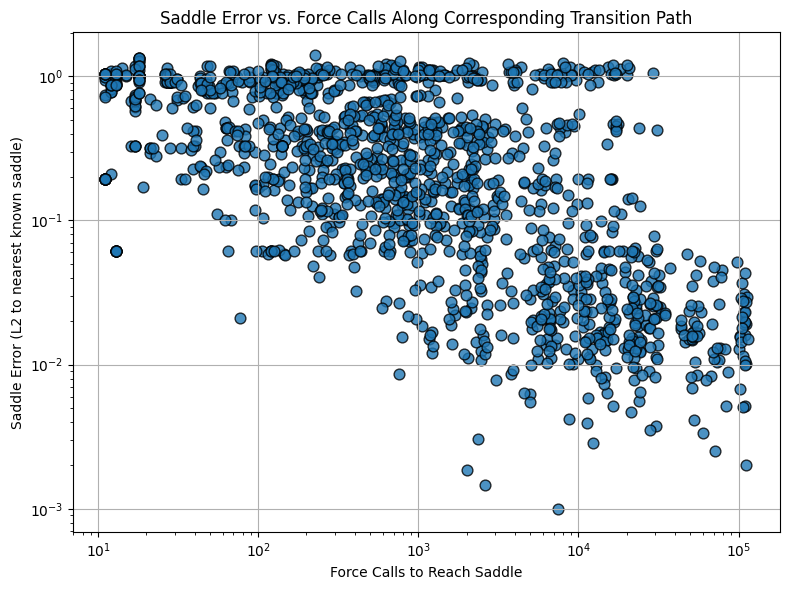

In [112]:
import matplotlib.pyplot as plt

# Collect per-saddle data from each run
saddle_force_data = []

for _, row in full_df.iterrows():
    errors = row['saddle_error_list']
    force_steps = row['force_incements']
    
    for i, err in enumerate(errors):
        if i + 1 < len(force_steps):
            saddle_force_data.append({
                'run_id': row['run_id'],
                'saddle_index': i,
                'saddle_error': err,
                'force_calls_to_saddle': force_steps[i + 1],  # n+1-th increment
            })

saddle_df = pd.DataFrame(saddle_force_data)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(
    saddle_df['force_calls_to_saddle'],
    saddle_df['saddle_error'],
    alpha=0.8,
    s=60,
    c='tab:blue',
    edgecolors='k'
)

plt.xlabel("Force Calls to Reach Saddle")
plt.ylabel("Saddle Error (L2 to nearest known saddle)")
plt.title("Saddle Error vs. Force Calls Along Corresponding Transition Path")
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()


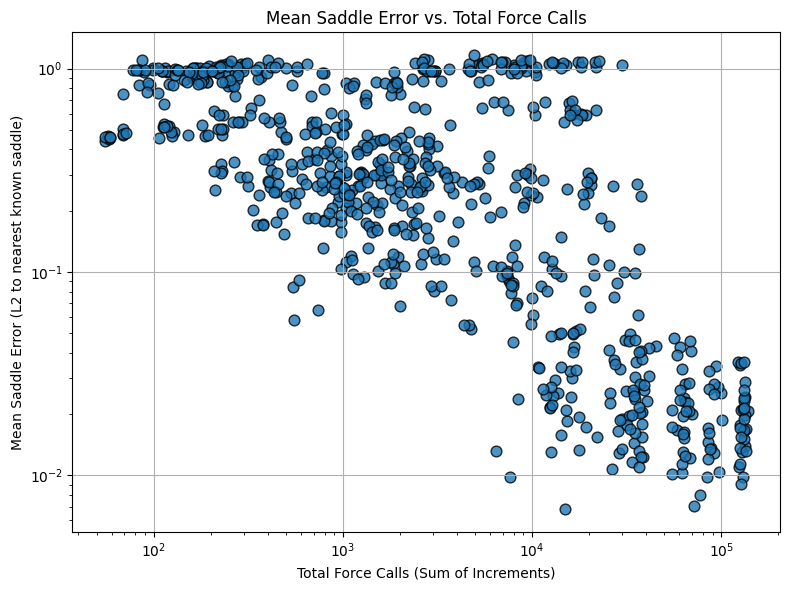

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Safely compute total force calls by summing increments
full_df['total_force_calls'] = full_df['force_incements'].apply(lambda lst: np.sum(lst) if len(lst) > 0 else np.nan)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    full_df['total_force_calls'],
    full_df['saddle_error_mean'],
    alpha=0.8,
    s=60,
    c='tab:blue',
    edgecolors='k'
)

plt.xlabel("Total Force Calls (Sum of Increments)")
plt.ylabel("Mean Saddle Error (L2 to nearest known saddle)")
plt.title("Mean Saddle Error vs. Total Force Calls")
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()


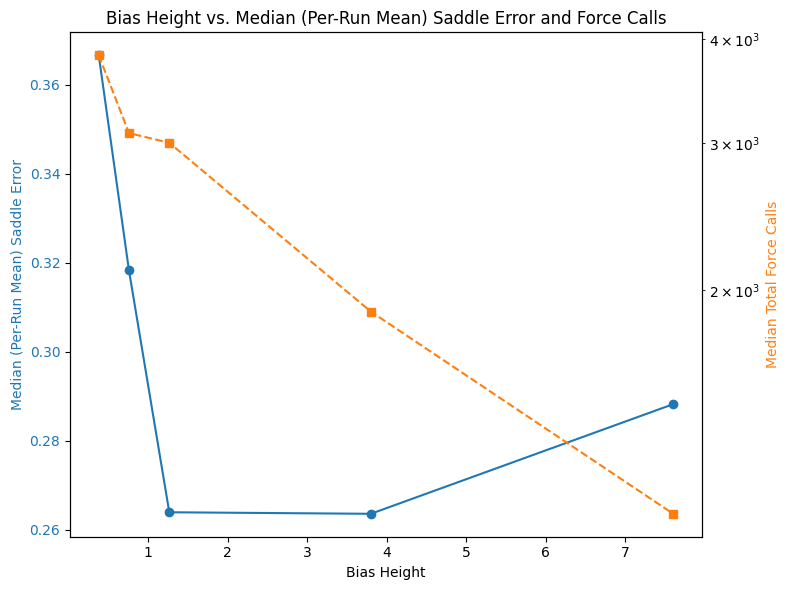

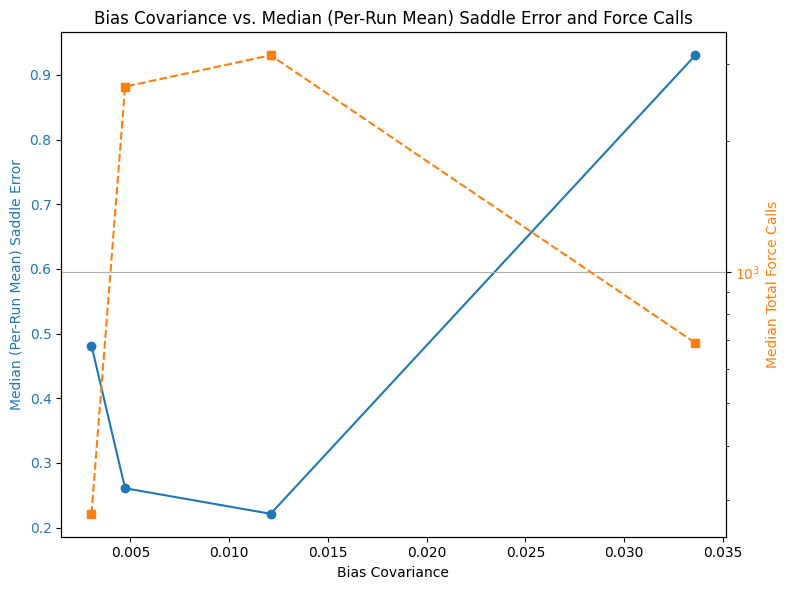

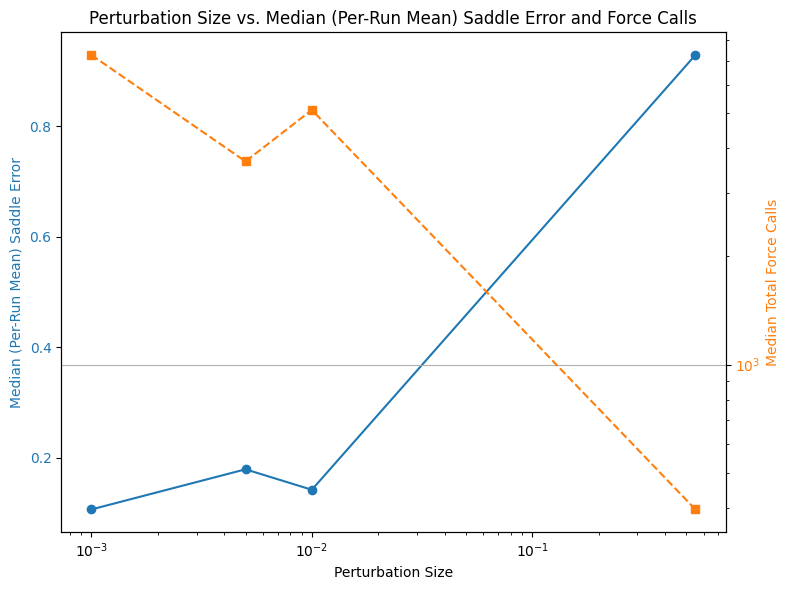

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure total_force_calls is computed correctly
full_df['total_force_calls'] = full_df['force_incements'].apply(
    lambda lst: np.sum(lst) if isinstance(lst, (list, np.ndarray)) and len(lst) > 0 else np.nan
)

# Parameters to plot
param_names = ['bias_height', 'bias_covariance', 'perturbation_size']

for param in param_names:
    # Group by parameter value, then compute medians
    medians_df = full_df.groupby(param).agg(
        median_saddle_error=('saddle_error_mean', 'median'),
        median_force_calls=('total_force_calls', 'median')
    ).reset_index().sort_values(param)

    x = medians_df[param]
    y_error = medians_df['median_saddle_error']
    y_force = medians_df['median_force_calls']

    # Plot
    fig, ax1 = plt.subplots(figsize=(8, 6))
    color1 = 'tab:blue'
    color2 = 'tab:orange'

    ax1.set_xlabel(param.replace('_', ' ').title())
    ax1.set_ylabel('Median (Per-Run Mean) Saddle Error', color=color1)
    ax1.plot(x, y_error, 'o-', color=color1, label='Median Saddle Error')
    ax1.tick_params(axis='y', labelcolor=color1)
    # ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Median Total Force Calls', color=color2)
    ax2.plot(x, y_force, 's--', color=color2, label='Median Force Calls')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_yscale('log')
    if param == "perturbation_size":
        ax2.set_xscale('log')

    plt.title(f"{param.replace('_', ' ').title()} vs. Median (Per-Run Mean) Saddle Error and Force Calls")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


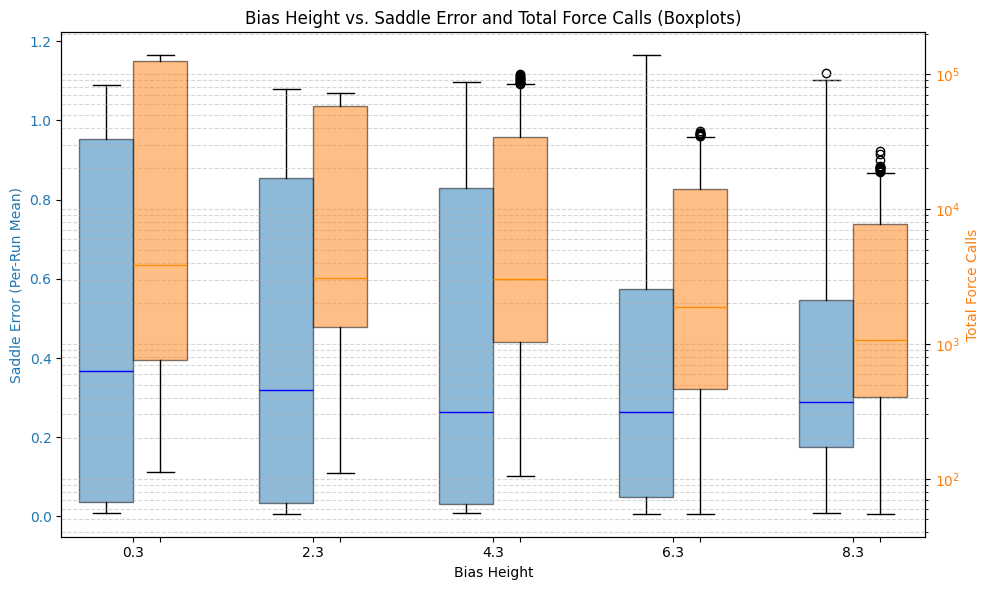

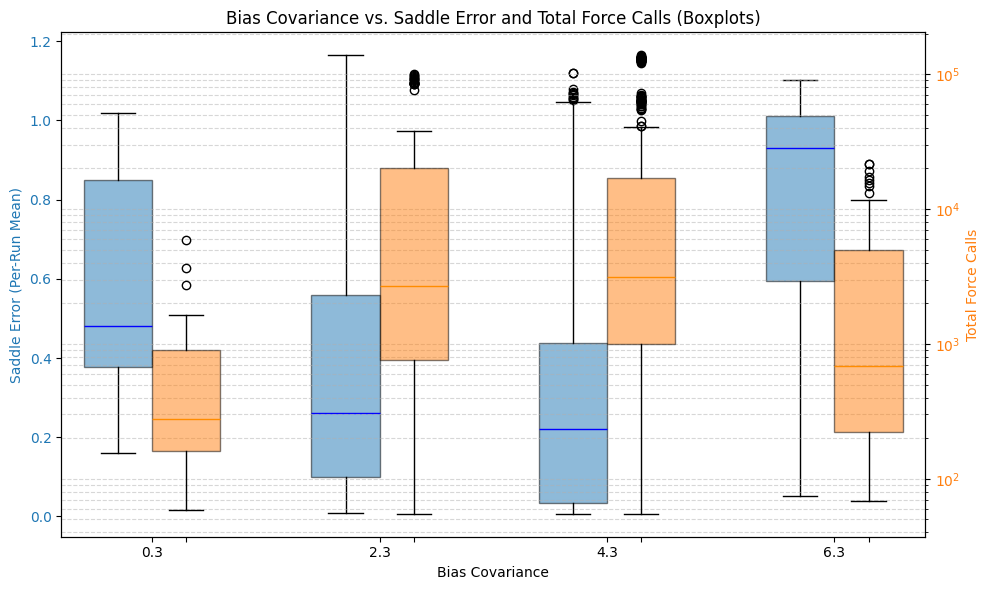

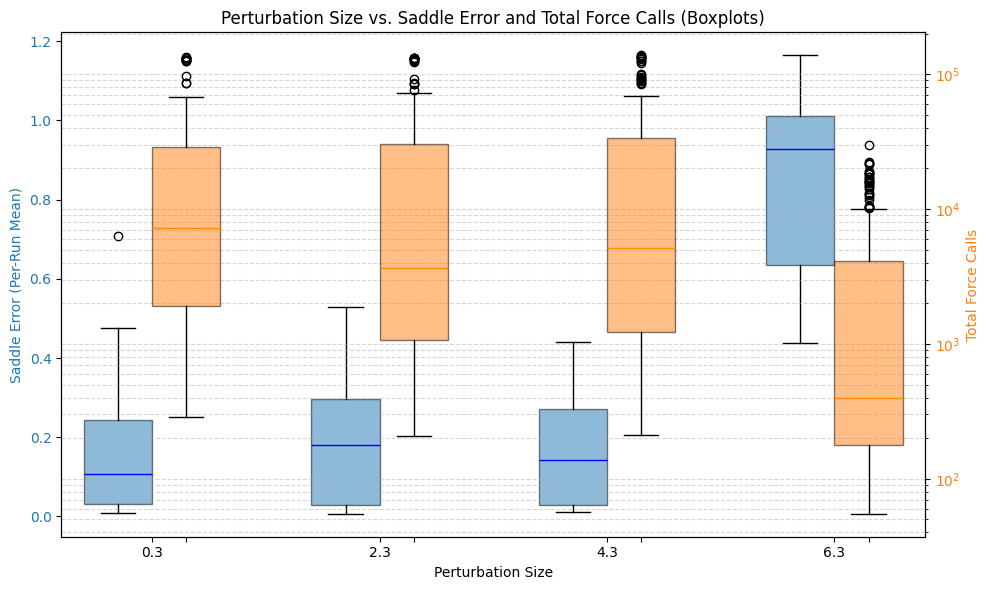

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute total_force_calls if not done yet
full_df['total_force_calls'] = full_df['force_incements'].apply(
    lambda lst: np.sum(lst) if isinstance(lst, (list, np.ndarray)) and len(lst) > 0 else np.nan
)

param_names = ['bias_height', 'bias_covariance', 'perturbation_size']

for param in param_names:
    # Sort unique parameter values for consistent plotting order
    param_values = sorted(full_df[param].dropna().unique())

    # Prepare data for boxplots: lists of arrays for each group
    error_data = [full_df.loc[full_df[param] == val, 'saddle_error_mean'].dropna() for val in param_values]
    force_data = [full_df.loc[full_df[param] == val, 'total_force_calls'].dropna() for val in param_values]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    color1 = 'tab:blue'
    color2 = 'tab:orange'

    # Boxplot for saddle_error_mean
    bp1 = ax1.boxplot(error_data, positions=np.arange(len(param_values)) * 2.0 - 0.3,
                      widths=0.6, patch_artist=True, boxprops=dict(facecolor=color1, alpha=0.5),
                      medianprops=dict(color='blue'), showfliers=True)
    ax1.set_ylabel('Saddle Error (Per-Run Mean)', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xticks(np.arange(len(param_values)) * 2.0)
    ax1.set_xticklabels([str(v) for v in param_values])
    ax1.set_xlabel(param.replace('_', ' ').title())

    # Twin axis for total_force_calls
    ax2 = ax1.twinx()

    # Boxplot for total_force_calls
    bp2 = ax2.boxplot(force_data, positions=np.arange(len(param_values)) * 2.0 + 0.3,
                      widths=0.6, patch_artist=True, boxprops=dict(facecolor=color2, alpha=0.5),
                      medianprops=dict(color='darkorange'), showfliers=True)
    ax2.set_ylabel('Total Force Calls', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    # If perturbation_size, use log scale for x-axis and optionally y-axis for force calls
    # if param == "perturbation_size":
    #     ax1.set_xscale('log')
    ax2.set_yscale('log')

    plt.title(f"{param.replace('_', ' ').title()} vs. Saddle Error and Total Force Calls (Boxplots)")
    plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


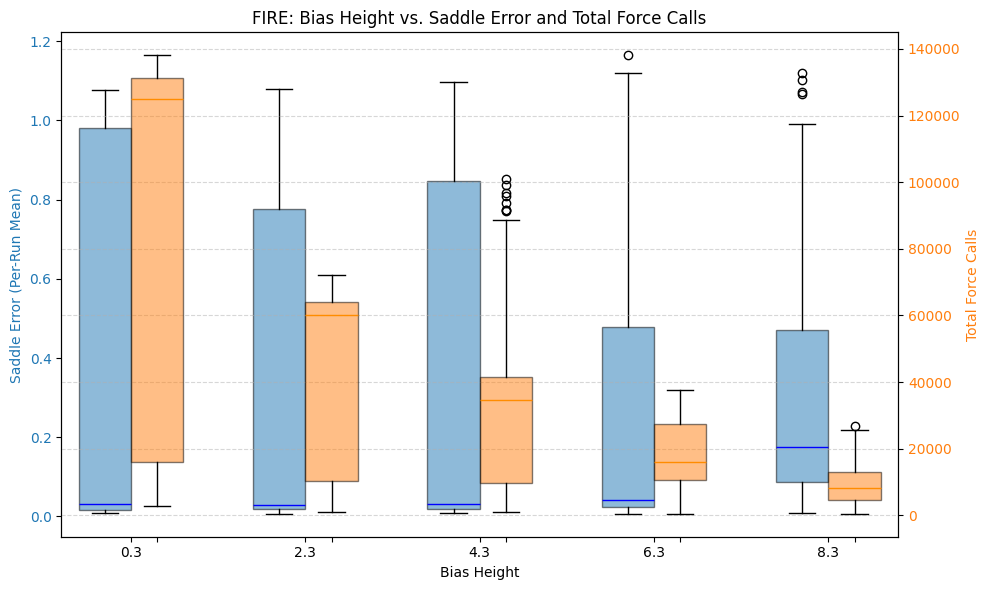

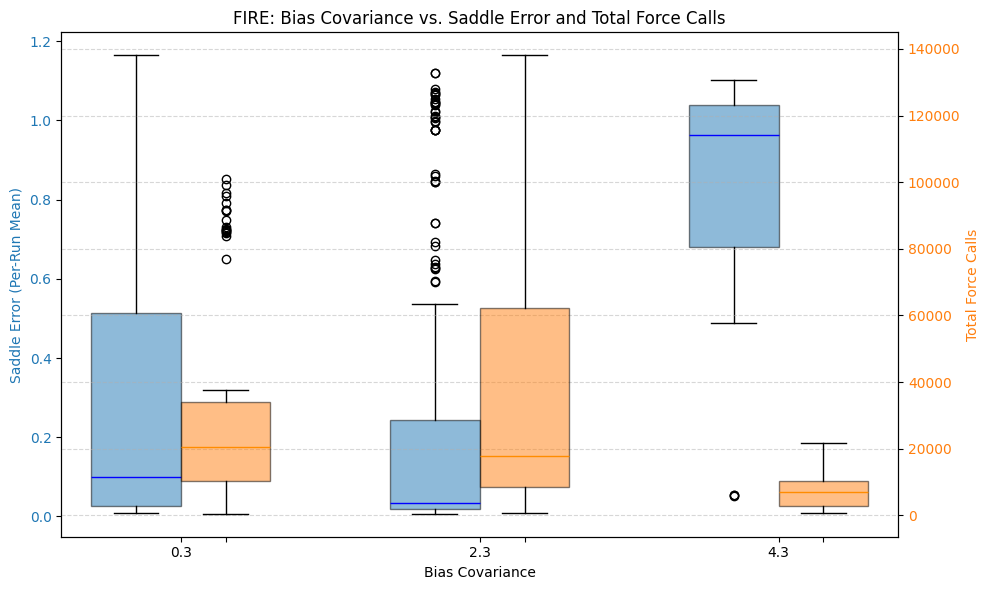

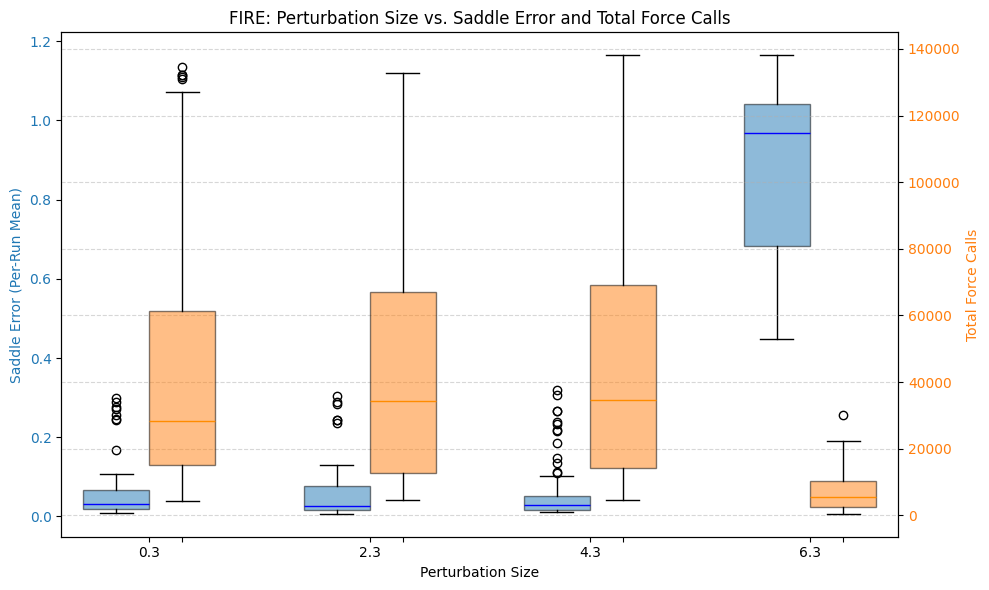

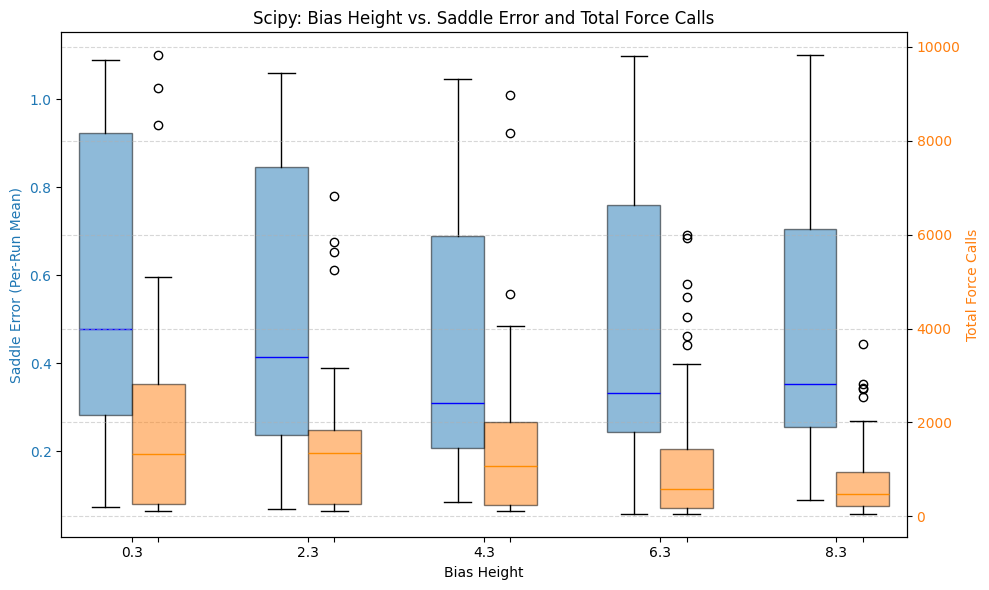

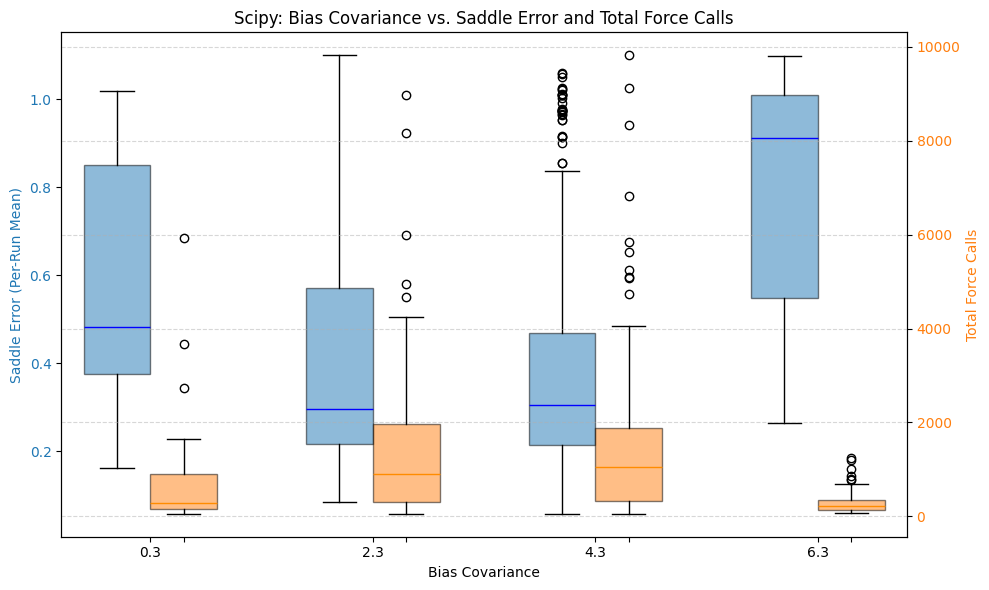

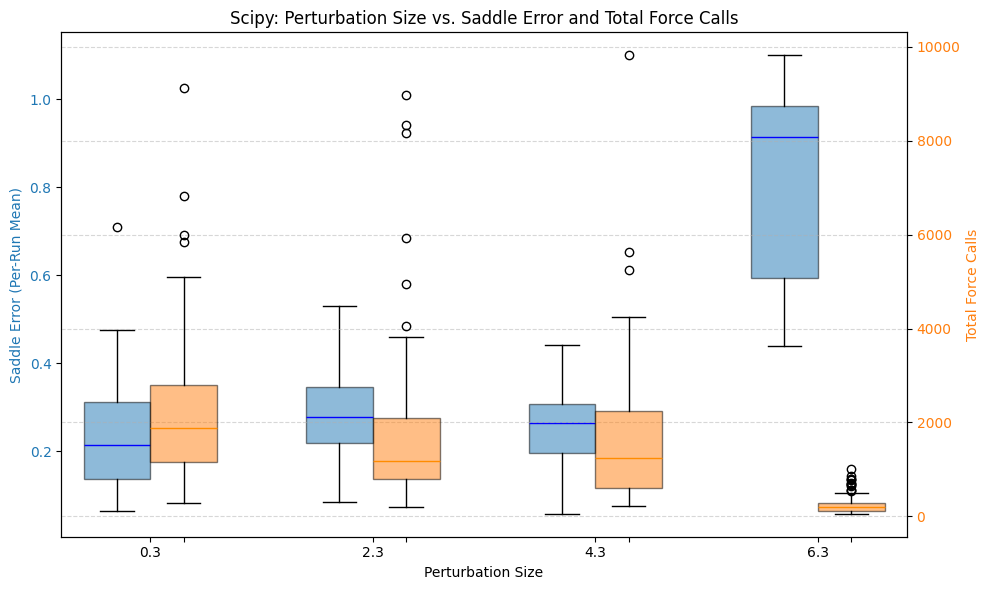

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute total_force_calls if not already present
full_df['total_force_calls'] = full_df['force_incements'].apply(
    lambda lst: np.sum(lst) if isinstance(lst, (list, np.ndarray)) and len(lst) > 0 else np.nan
)

param_names = ['bias_height', 'bias_covariance', 'perturbation_size']
optimizers = ['FIRE', 'Scipy']

for optimizer in optimizers:
    optimizer_df = full_df[full_df['optimizer'] == optimizer].copy()

    for param in param_names:
        # Sort unique parameter values for consistent plotting order
        param_values = sorted(optimizer_df[param].dropna().unique())

        # Prepare data for boxplots: lists of arrays for each group
        error_data = [optimizer_df.loc[optimizer_df[param] == val, 'saddle_error_mean'].dropna()
                      for val in param_values]
        force_data = [optimizer_df.loc[optimizer_df[param] == val, 'total_force_calls'].dropna()
                      for val in param_values]

        fig, ax1 = plt.subplots(figsize=(10, 6))
        color1 = 'tab:blue'
        color2 = 'tab:orange'

        # Boxplot for saddle_error_mean
        bp1 = ax1.boxplot(error_data, positions=np.arange(len(param_values)) * 2.0 - 0.3,
                          widths=0.6, patch_artist=True, boxprops=dict(facecolor=color1, alpha=0.5),
                          medianprops=dict(color='blue'), showfliers=True)
        ax1.set_ylabel('Saddle Error (Per-Run Mean)', color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.set_xticks(np.arange(len(param_values)) * 2.0)
        ax1.set_xticklabels([f"{v:.3g}" for v in param_values])
        ax1.set_xlabel(param.replace('_', ' ').title())

        # Twin axis for total_force_calls
        ax2 = ax1.twinx()

        # Boxplot for total_force_calls
        bp2 = ax2.boxplot(force_data, positions=np.arange(len(param_values)) * 2.0 + 0.3,
                          widths=0.6, patch_artist=True, boxprops=dict(facecolor=color2, alpha=0.5),
                          medianprops=dict(color='darkorange'), showfliers=True)
        ax2.set_ylabel('Total Force Calls', color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)

        # ax1.set_yscale('log')
        # ax2.set_yscale('log')
        plt.title(f"{optimizer}: {param.replace('_', ' ').title()} vs. Saddle Error and Total Force Calls")
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


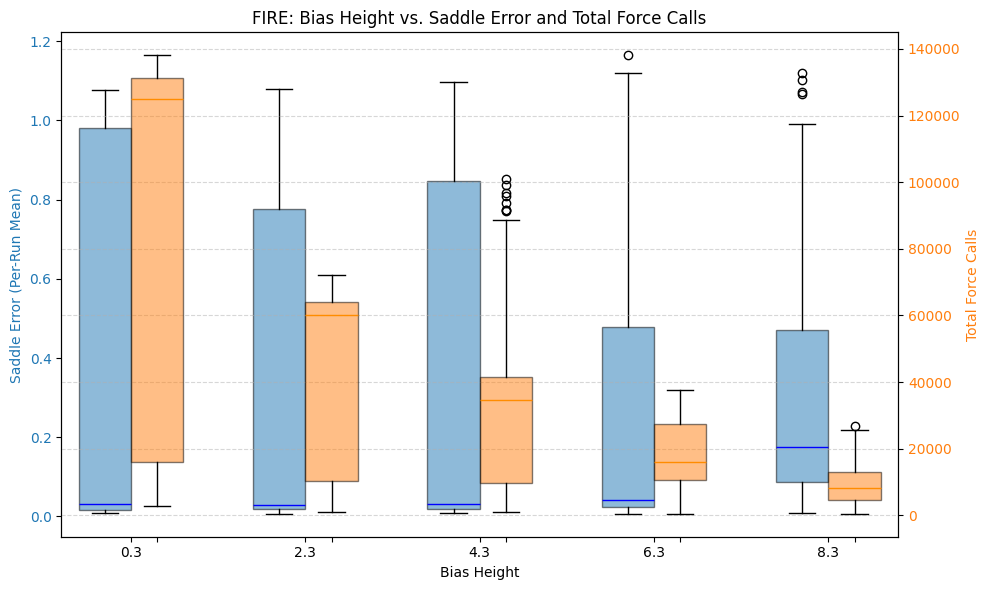

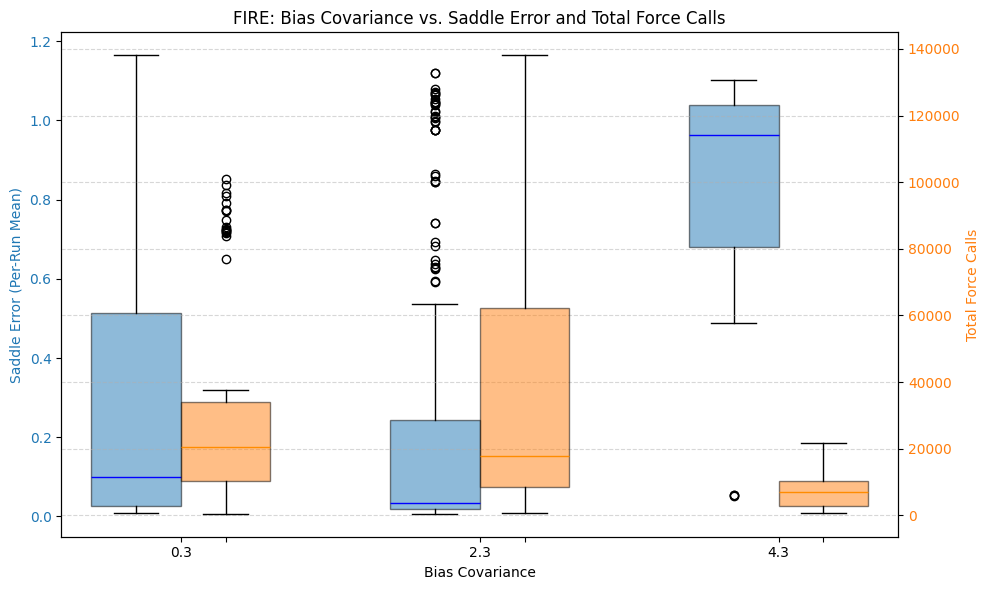

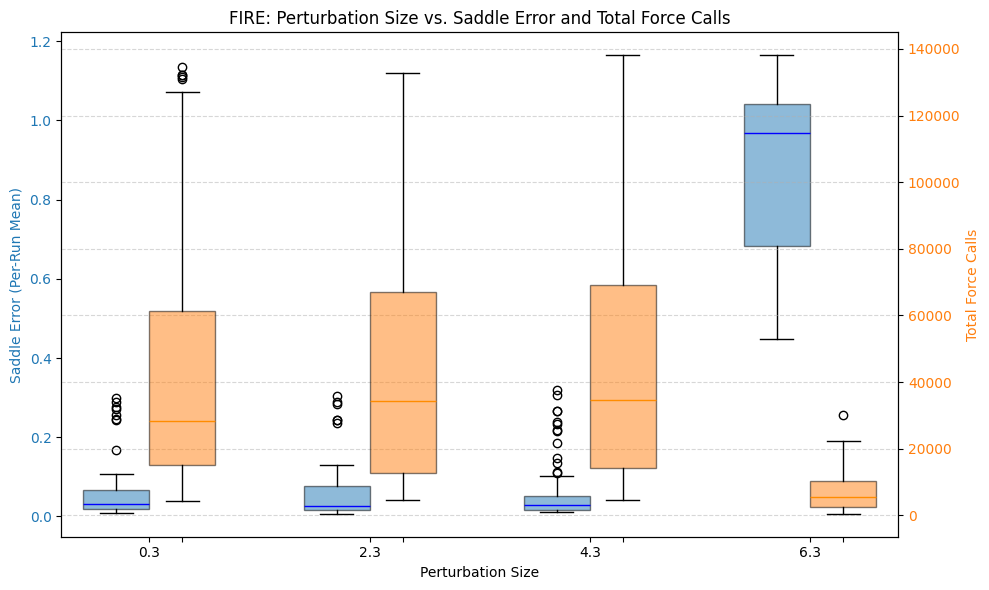

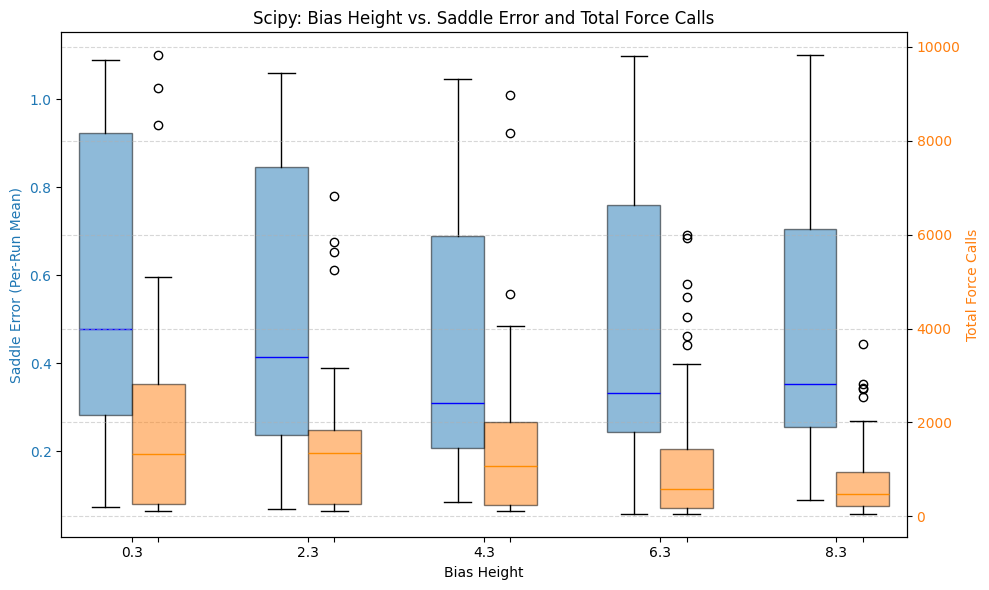

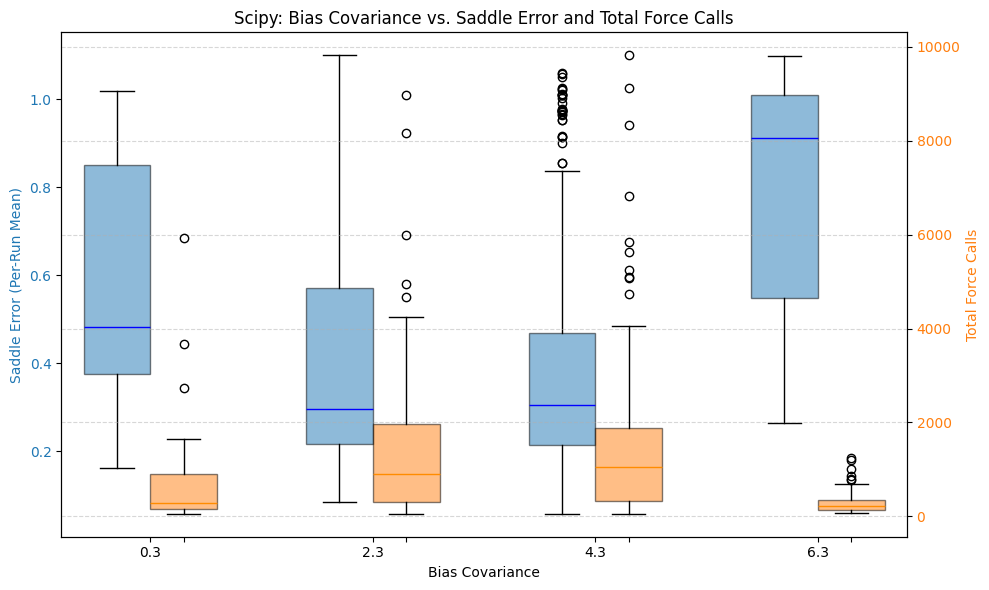

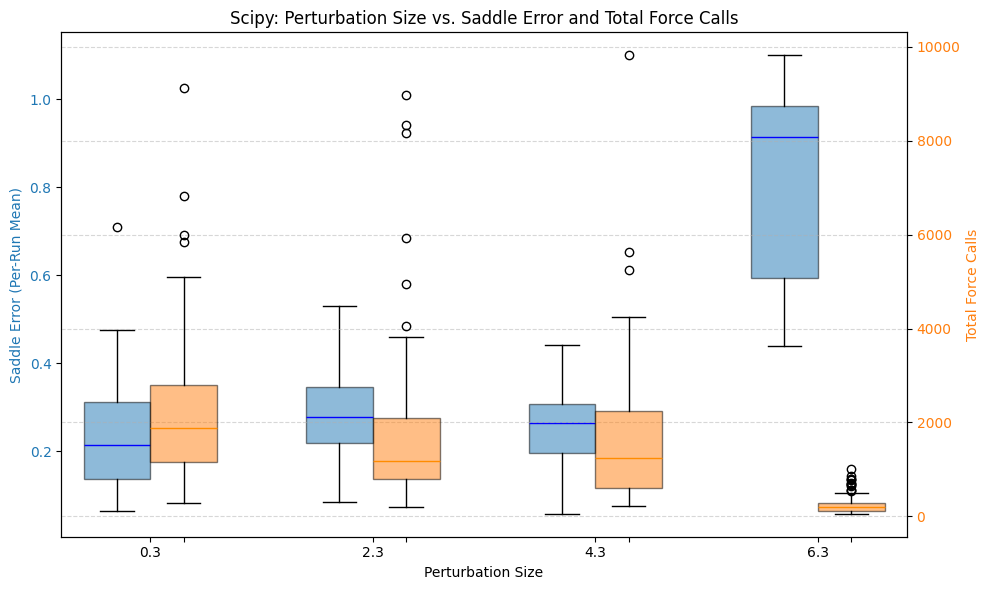

In [170]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute total_force_calls if not already present
full_df['total_force_calls'] = full_df['force_incements'].apply(
    lambda lst: np.sum(lst) if isinstance(lst, (list, np.ndarray)) and len(lst) > 0 else np.nan
)

param_names = ['bias_height', 'bias_covariance', 'perturbation_size']
optimizers = ['FIRE', 'Scipy']

for optimizer in optimizers:
    optimizer_df = full_df[full_df['optimizer'] == optimizer].copy()

    for param in param_names:
        # Sort unique parameter values for consistent plotting order
        param_values = sorted(optimizer_df[param].dropna().unique())

        filtered_vals = []
        error_data = []
        force_data = []

        # Filter out empty data groups and keep param values aligned
        for val in param_values:
            err_vals = optimizer_df.loc[optimizer_df[param] == val, 'saddle_error_mean'].dropna()
            frc_vals = optimizer_df.loc[optimizer_df[param] == val, 'total_force_calls'].dropna()

            if len(err_vals) > 0 and len(frc_vals) > 0:
                filtered_vals.append(val)
                error_data.append(err_vals)
                force_data.append(frc_vals)

        positions = np.arange(len(filtered_vals)) * 2.0

        fig, ax1 = plt.subplots(figsize=(10, 6))
        color1 = 'tab:blue'
        color2 = 'tab:orange'

        # Boxplot for saddle_error_mean
        ax1.boxplot(error_data, positions=positions - 0.3,
                    widths=0.6, patch_artist=True,
                    boxprops=dict(facecolor=color1, alpha=0.5),
                    medianprops=dict(color='blue'), showfliers=True)
        ax1.set_ylabel('Saddle Error (Per-Run Mean)', color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.set_xticks(positions)
        ax1.set_xticklabels([f"{v:.3g}" for v in filtered_vals])
        ax1.set_xlabel(param.replace('_', ' ').title())

        # Twin axis for total_force_calls
        ax2 = ax1.twinx()

        # Boxplot for total_force_calls
        ax2.boxplot(force_data, positions=positions + 0.3,
                    widths=0.6, patch_artist=True,
                    boxprops=dict(facecolor=color2, alpha=0.5),
                    medianprops=dict(color='darkorange'), showfliers=True)
        ax2.set_ylabel('Total Force Calls', color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)

        plt.title(f"{optimizer}: {param.replace('_', ' ').title()} vs. Saddle Error and Total Force Calls")
        plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


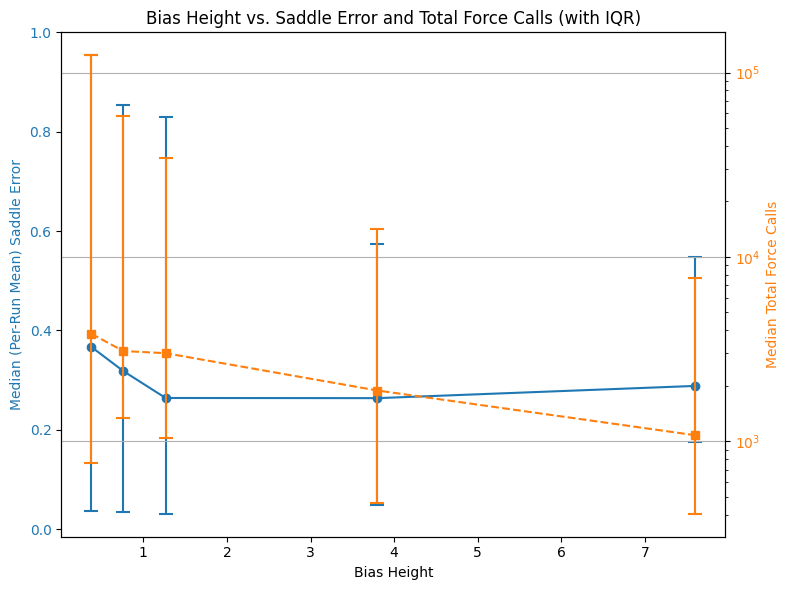

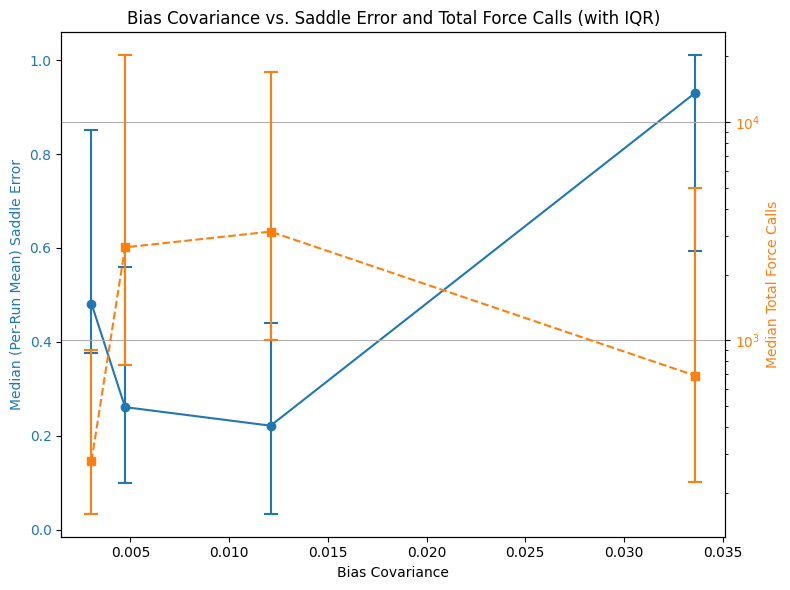

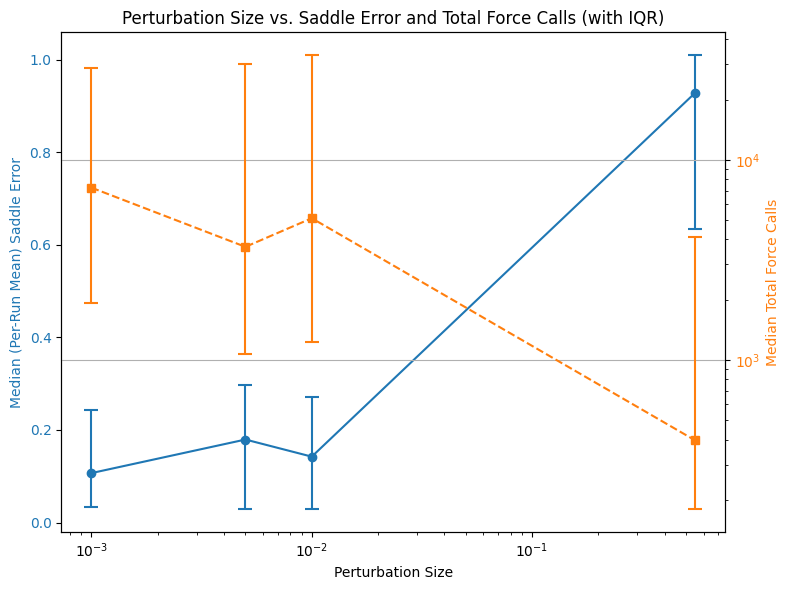

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure total_force_calls is computed correctly
full_df['total_force_calls'] = full_df['force_incements'].apply(
    lambda lst: np.sum(lst) if isinstance(lst, (list, np.ndarray)) and len(lst) > 0 else np.nan
)

param_names = ['bias_height', 'bias_covariance', 'perturbation_size']

for param in param_names:
    grouped = full_df.groupby(param)

    # Saddle Error: median, Q1, Q3
    median_error = grouped['saddle_error_mean'].median()
    q1_error = grouped['saddle_error_mean'].quantile(0.25)
    q3_error = grouped['saddle_error_mean'].quantile(0.75)

    # Force Calls: median, Q1, Q3
    median_force = grouped['total_force_calls'].median()
    q1_force = grouped['total_force_calls'].quantile(0.25)
    q3_force = grouped['total_force_calls'].quantile(0.75)

    # Sort by param for consistent x-axis
    x = median_error.index.values
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]

    # Saddle error stats
    med_err_sorted = median_error.values[sort_idx]
    q1_err_sorted = q1_error.values[sort_idx]
    q3_err_sorted = q3_error.values[sort_idx]
    err_err_lower = med_err_sorted - q1_err_sorted
    err_err_upper = q3_err_sorted - med_err_sorted

    # Force call stats
    med_force_sorted = median_force.values[sort_idx]
    q1_force_sorted = q1_force.values[sort_idx]
    q3_force_sorted = q3_force.values[sort_idx]
    force_err_lower = med_force_sorted - q1_force_sorted
    force_err_upper = q3_force_sorted - med_force_sorted

    # Plot
    fig, ax1 = plt.subplots(figsize=(8, 6))
    color1 = 'tab:blue'
    color2 = 'tab:orange'

    ax1.set_xlabel(param.replace('_', ' ').title())
    ax1.set_ylabel('Median (Per-Run Mean) Saddle Error', color=color1)
    ax1.errorbar(
        x_sorted, med_err_sorted,
        yerr=[err_err_lower, err_err_upper],
        fmt='o-', color=color1,
        capsize=5, capthick=1.5,
        label='Saddle Error (Median ± IQR)'
    )
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Median Total Force Calls', color=color2)
    ax2.errorbar(
        x_sorted, med_force_sorted,
        yerr=[force_err_lower, force_err_upper],
        fmt='s--', color=color2,
        capsize=5, capthick=1.5,
        label='Force Calls (Median ± IQR)'
    )
    ax2.tick_params(axis='y', labelcolor=color2)

    if param == "perturbation_size":
        ax1.set_xscale('log')
        ax2.set_xscale('log')

    ax2.set_yscale('log')

    plt.title(f"{param.replace('_', ' ').title()} vs. Saddle Error and Total Force Calls (with IQR)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


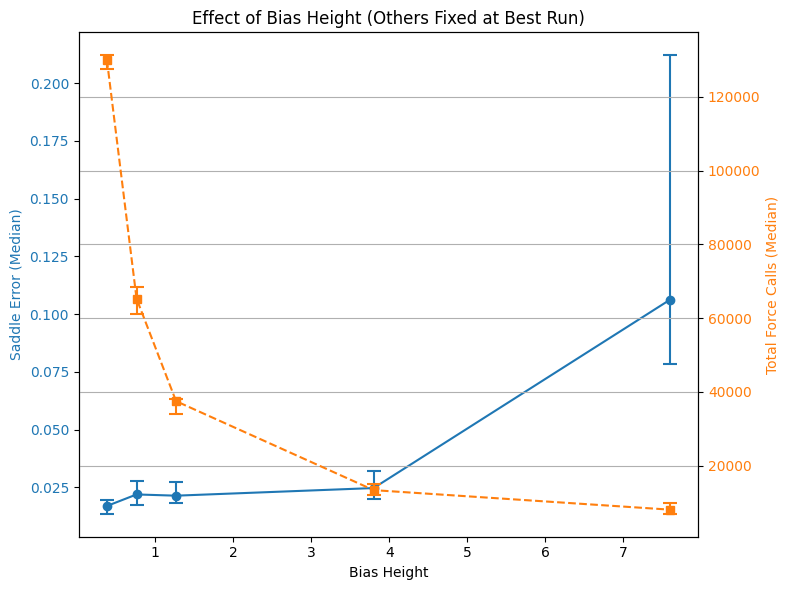

             count    median       iqr       min       max
bias_height                                               
0.380000        10  0.016923  0.005977  0.009792  0.021213
0.760000        10  0.021922  0.010691  0.007105  0.045921
1.266667        10  0.021388  0.009320  0.011601  0.042375
3.800000        10  0.024687  0.012207  0.006802  0.049699
7.600000        10  0.106216  0.133843  0.013239  0.303882


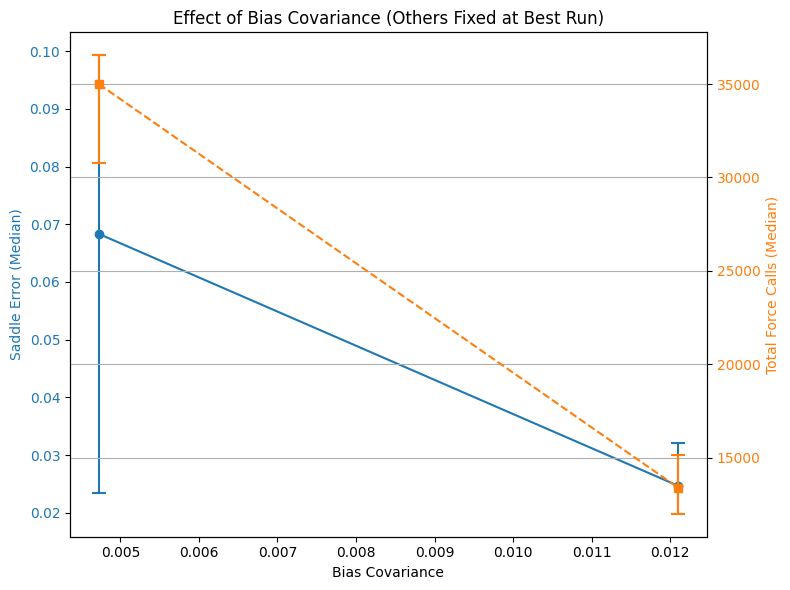

                 count    median       iqr       min       max
bias_covariance                                               
0.004727            10  0.068315  0.075851  0.013405  0.236003
0.012100            10  0.024687  0.012207  0.006802  0.049699


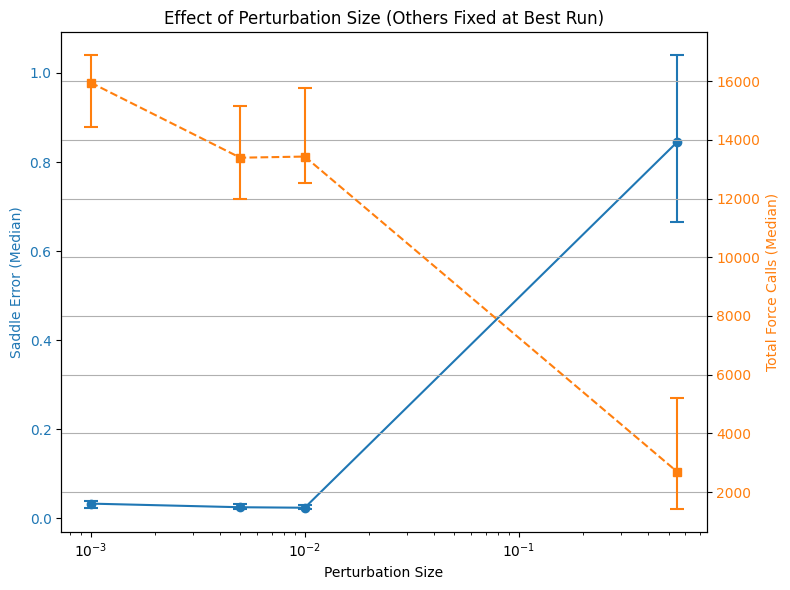

                   count    median       iqr       min       max
perturbation_size                                               
0.001                 10  0.032831  0.016045  0.017239  0.051459
0.005                 10  0.024687  0.012207  0.006802  0.049699
0.010                 10  0.023572  0.010185  0.013007  0.042786
0.550                 10  0.845378  0.375875  0.488789  1.118625


In [163]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure total_force_calls is computed
full_df['total_force_calls'] = full_df['force_incements'].apply(
    lambda lst: np.sum(lst) if isinstance(lst, (list, np.ndarray)) and len(lst) > 0 else np.nan
)

# Parameters of interest
param_names = ['bias_height', 'bias_covariance', 'perturbation_size']

# Find best run by lowest saddle_error_mean
best_idx = full_df['saddle_error_mean'].idxmin()
best_row = full_df.loc[best_idx]

# Loop over each parameter and vary it while fixing the others
old_full = full_df.copy()
full_df = full_df[full_df['optimizer'] == 'FIRE'].copy()
for param in param_names:
    # Identify the other parameters to fix
    other_params = [p for p in param_names if p != param]

    # Filter to rows that match the best run on the other parameters
    subset = full_df.copy()
    for p in other_params:
        subset = subset[subset[p] == best_row[p]]

    # Drop NaNs
    subset = subset.dropna(subset=['saddle_error_mean', 'total_force_calls', param])

    # Group by the parameter of interest
    grouped = subset.groupby(param)

    # Compute median and IQR
    med_error = grouped['saddle_error_mean'].median()
    q1_error = grouped['saddle_error_mean'].quantile(0.25)
    q3_error = grouped['saddle_error_mean'].quantile(0.75)

    med_force = grouped['total_force_calls'].median()
    q1_force = grouped['total_force_calls'].quantile(0.25)
    q3_force = grouped['total_force_calls'].quantile(0.75)

    # X-axis values (sorted for plotting)
    x_vals = med_error.index.values
    sort_idx = np.argsort(x_vals)
    x_sorted = x_vals[sort_idx]

    # Errors
    err_med = med_error.values[sort_idx]
    err_lower = err_med - q1_error.values[sort_idx]
    err_upper = q3_error.values[sort_idx] - err_med

    force_med = med_force.values[sort_idx]
    force_lower = force_med - q1_force.values[sort_idx]
    force_upper = q3_force.values[sort_idx] - force_med

    # Plot
    fig, ax1 = plt.subplots(figsize=(8, 6))
    color1 = 'tab:blue'
    color2 = 'tab:orange'

    ax1.set_xlabel(param.replace('_', ' ').title())
    ax1.set_ylabel('Saddle Error (Median)', color=color1)
    ax1.errorbar(
        x_sorted, err_med,
        yerr=[err_lower, err_upper],
        fmt='o-', color=color1, capsize=5, capthick=1.5
    )
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Total Force Calls (Median)', color=color2)
    ax2.errorbar(
        x_sorted, force_med,
        yerr=[force_lower, force_upper],
        fmt='s--', color=color2, capsize=5, capthick=1.5
    )
    ax2.tick_params(axis='y', labelcolor=color2)

    if param == 'perturbation_size':
        ax1.set_xscale('log')
        ax2.set_xscale('log')

    # ax2.set_yscale('log')

    plt.title(f"Effect of {param.replace('_', ' ').title()} (Others Fixed at Best Run)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(subset.groupby(param).agg(
        count=('saddle_error_mean', 'count'),
        median=('saddle_error_mean', 'median'),
        iqr=('saddle_error_mean', lambda x: x.quantile(0.75) - x.quantile(0.25)),
        min=('saddle_error_mean', 'min'),
        max=('saddle_error_mean', 'max')
    ))

full_df = old_full.copy()

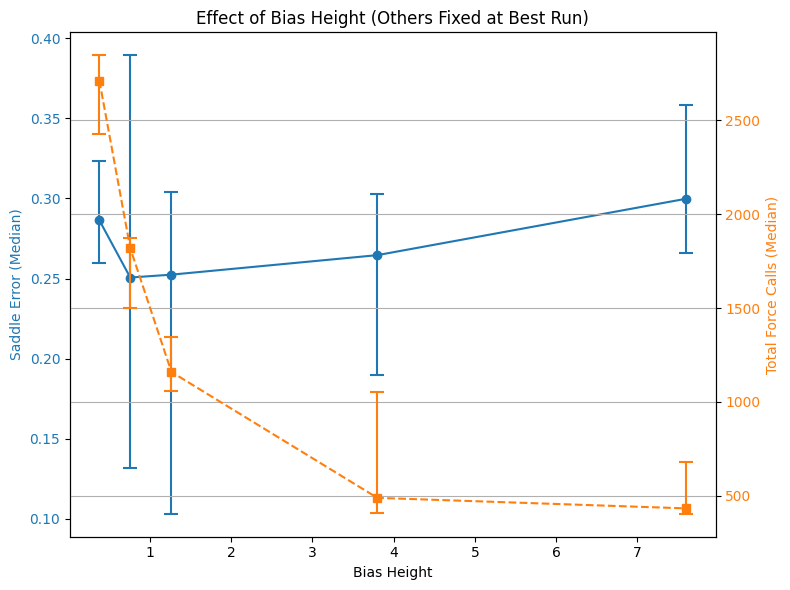

             count    median       iqr       min       max
bias_height                                               
0.380000        10  0.286360  0.063718  0.172841  0.425168
0.760000        10  0.250628  0.257980  0.099121  0.437754
1.266667        10  0.252428  0.200730  0.092117  0.395660
3.800000        10  0.264617  0.113495  0.058029  0.315870
7.600000        10  0.299850  0.092105  0.175213  0.380472


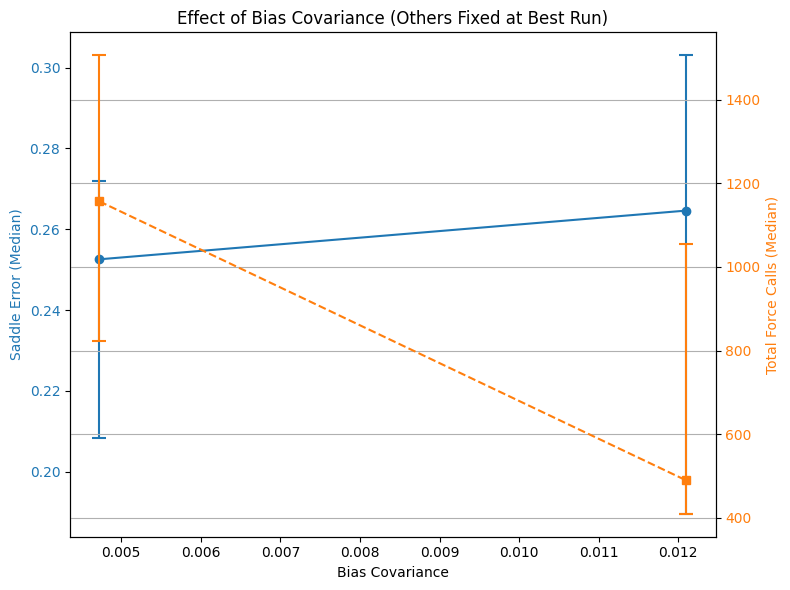

                 count    median       iqr       min       max
bias_covariance                                               
0.004727            10  0.252559  0.063645  0.131180  0.278007
0.012100            10  0.264617  0.113495  0.058029  0.315870


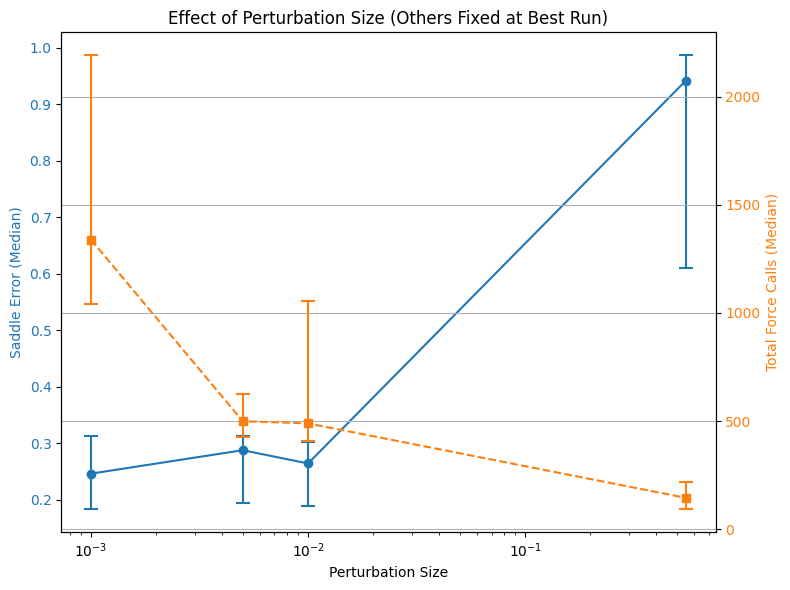

                   count    median       iqr       min       max
perturbation_size                                               
0.001                 10  0.246631  0.130530  0.065322  0.358201
0.005                 10  0.288055  0.117490  0.084108  0.394552
0.010                 10  0.264617  0.113495  0.058029  0.315870
0.550                 10  0.942178  0.377717  0.465384  1.056235


In [164]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure total_force_calls is computed
full_df['total_force_calls'] = full_df['force_incements'].apply(
    lambda lst: np.sum(lst) if isinstance(lst, (list, np.ndarray)) and len(lst) > 0 else np.nan
)

# Parameters of interest
param_names = ['bias_height', 'bias_covariance', 'perturbation_size']
old_full = full_df.copy()

full_df = full_df[full_df['optimizer'] == 'Scipy'].copy()


# Find best run by lowest saddle_error_mean
best_idx = full_df['saddle_error_mean'].idxmin()
best_row = full_df.loc[best_idx]

# Loop over each parameter and vary it while fixing the others
for param in param_names:
    # Identify the other parameters to fix
    other_params = [p for p in param_names if p != param]

    # Filter to rows that match the best run on the other parameters
    subset = full_df.copy()
    for p in other_params:
        subset = subset[subset[p] == best_row[p]]

    # Drop NaNs
    subset = subset.dropna(subset=['saddle_error_mean', 'total_force_calls', param])

    # Group by the parameter of interest
    grouped = subset.groupby(param)

    # Compute median and IQR
    med_error = grouped['saddle_error_mean'].median()
    q1_error = grouped['saddle_error_mean'].quantile(0.25)
    q3_error = grouped['saddle_error_mean'].quantile(0.75)

    med_force = grouped['total_force_calls'].median()
    q1_force = grouped['total_force_calls'].quantile(0.25)
    q3_force = grouped['total_force_calls'].quantile(0.75)

    # X-axis values (sorted for plotting)
    x_vals = med_error.index.values
    sort_idx = np.argsort(x_vals)
    x_sorted = x_vals[sort_idx]

    # Errors
    err_med = med_error.values[sort_idx]
    err_lower = err_med - q1_error.values[sort_idx]
    err_upper = q3_error.values[sort_idx] - err_med

    force_med = med_force.values[sort_idx]
    force_lower = force_med - q1_force.values[sort_idx]
    force_upper = q3_force.values[sort_idx] - force_med

    # Plot
    fig, ax1 = plt.subplots(figsize=(8, 6))
    color1 = 'tab:blue'
    color2 = 'tab:orange'

    ax1.set_xlabel(param.replace('_', ' ').title())
    ax1.set_ylabel('Saddle Error (Median)', color=color1)
    ax1.errorbar(
        x_sorted, err_med,
        yerr=[err_lower, err_upper],
        fmt='o-', color=color1, capsize=5, capthick=1.5
    )
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Total Force Calls (Median)', color=color2)
    ax2.errorbar(
        x_sorted, force_med,
        yerr=[force_lower, force_upper],
        fmt='s--', color=color2, capsize=5, capthick=1.5
    )
    ax2.tick_params(axis='y', labelcolor=color2)

    if param == 'perturbation_size':
        ax1.set_xscale('log')
        ax2.set_xscale('log')

    # ax2.set_yscale('log')

    plt.title(f"Effect of {param.replace('_', ' ').title()} (Others Fixed at Best Run)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(subset.groupby(param).agg(
        count=('saddle_error_mean', 'count'),
        median=('saddle_error_mean', 'median'),
        iqr=('saddle_error_mean', lambda x: x.quantile(0.75) - x.quantile(0.25)),
        min=('saddle_error_mean', 'min'),
        max=('saddle_error_mean', 'max')
    ))

full_df = old_full.copy()

/tmp/ipykernel_151617/61666962.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


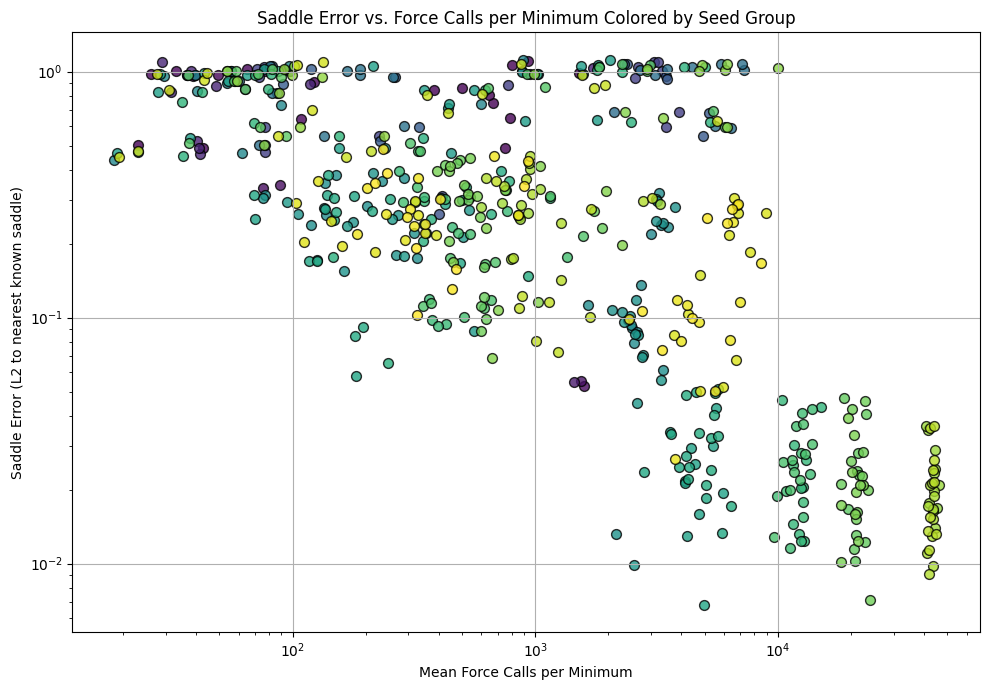

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

# Assign seed groups based on run_id: 1-10 → group 0, 11-20 → group 1, etc.
full_df['seed_group'] = ((full_df['run_id'] - 1) // 10).astype(int)

num_groups = full_df['seed_group'].nunique()

# Continuous colormap for smooth gradient across all groups
cmap = get_cmap('viridis')
norm = Normalize(vmin=0, vmax=num_groups - 1)

plt.figure(figsize=(10, 7))

for group_id in range(num_groups):
    group_mask = full_df['seed_group'] == group_id
    plt.scatter(
        full_df.loc[group_mask, 'mean_force_calls_per_min'],
        full_df.loc[group_mask, 'saddle_error_mean'],
        label=f'Runs {group_id*10 + 1}-{(group_id + 1)*10}',
        color=cmap(norm(group_id)),
        s=50, alpha=0.8, edgecolors='k'
    )

plt.xlabel("Mean Force Calls per Minimum")
plt.ylabel("Saddle Error (L2 to nearest known saddle)")
plt.title("Saddle Error vs. Force Calls per Minimum Colored by Seed Group")
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

# Optional legend - uncomment if you want it
# plt.legend(title="Run Groups", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


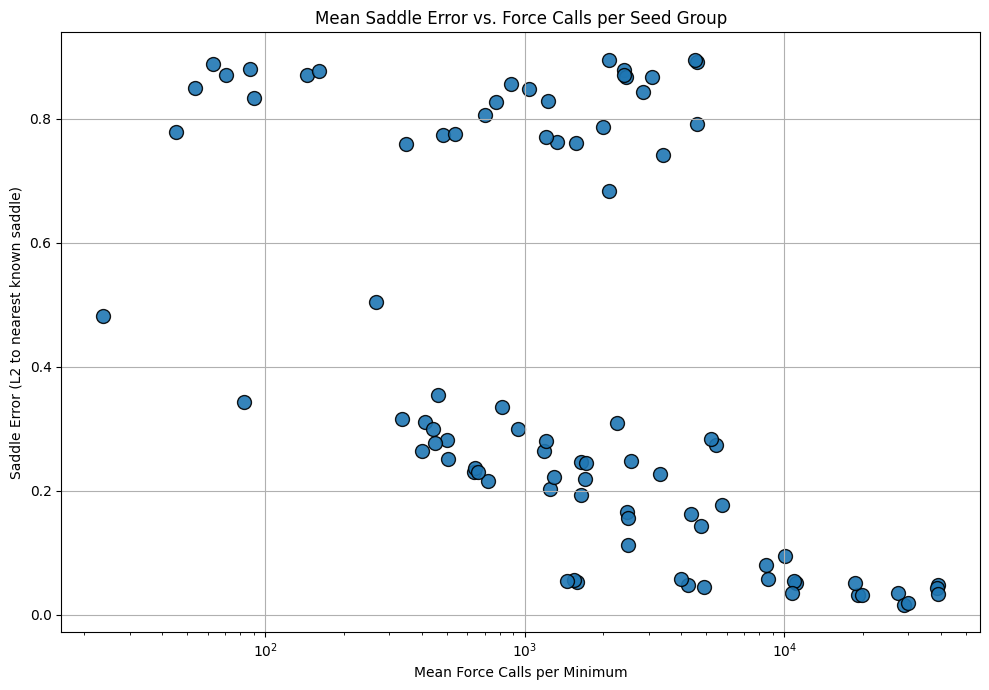

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assign seed groups based on run_id: 1-10 → group 0, 11-20 → group 1, etc.
full_df['seed_group'] = ((full_df['run_id'] - 1) // 10).astype(int)

# Group by seed_group and take the mean of each column
group_means = full_df.groupby('seed_group').agg({
    'mean_force_calls_per_min': 'mean',
    'saddle_error_mean': 'mean'
}).reset_index()

# Plotting
plt.figure(figsize=(10, 7))
# cmap = plt.get_cmap('tab10')

for _, row in group_means.iterrows():
    group_id = int(row['seed_group'])
    plt.scatter(
        row['mean_force_calls_per_min'],
        row['saddle_error_mean'],
        label=f'Runs {group_id*10 + 1}-{(group_id + 1)*10}',
        color='tab:blue',
        s=100, alpha=0.9, edgecolors='k'
    )

plt.xlabel("Mean Force Calls per Minimum")
plt.ylabel("Saddle Error (L2 to nearest known saddle)")
plt.title("Mean Saddle Error vs. Force Calls per Seed Group")
plt.grid(True)
plt.xscale('log')
# plt.legend(title="Seed Groups", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_151617/3308843958.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


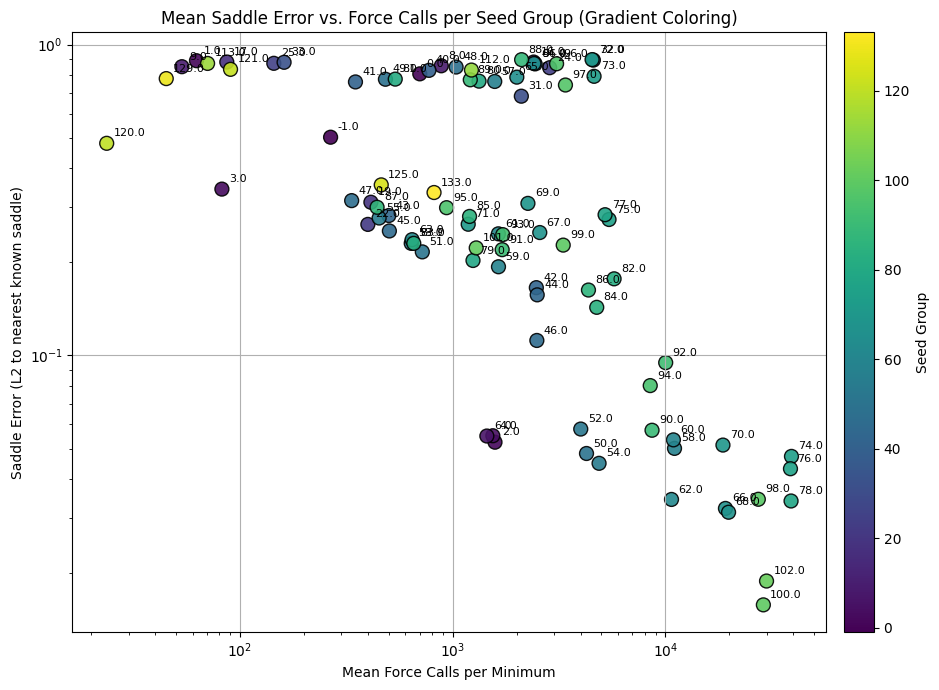

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

# Assign seed groups: 1–10 → 0, 11–20 → 1, etc.
full_df['seed_group'] = ((full_df['run_id'] - 1) // 10).astype(int)

# Compute group-wise means
group_means = full_df.groupby('seed_group').agg({
    'mean_force_calls_per_min': 'mean',
    'saddle_error_mean': 'mean'
}).reset_index()

# Normalize for color mapping
norm = Normalize(vmin=group_means['seed_group'].min(), vmax=group_means['seed_group'].max())
cmap = get_cmap('viridis')

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

# Store each point's color
colors = [cmap(norm(g)) for g in group_means['seed_group']]

# Create the scatter
sc = ax.scatter(
    group_means['mean_force_calls_per_min'],
    group_means['saddle_error_mean'],
    color=colors,
    s=100, alpha=0.9, edgecolors='k'
)

# Optional annotations
for _, row in group_means.iterrows():
    ax.annotate(f"{row['seed_group']}", 
                (row['mean_force_calls_per_min'], row['saddle_error_mean']),
                textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8)

# Axis formatting
ax.set_xlabel("Mean Force Calls per Minimum")
ax.set_ylabel("Saddle Error (L2 to nearest known saddle)")
ax.set_title("Mean Saddle Error vs. Force Calls per Seed Group (Gradient Coloring)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Seed Group")

plt.tight_layout()
plt.show()


/tmp/ipykernel_151617/1847229943.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


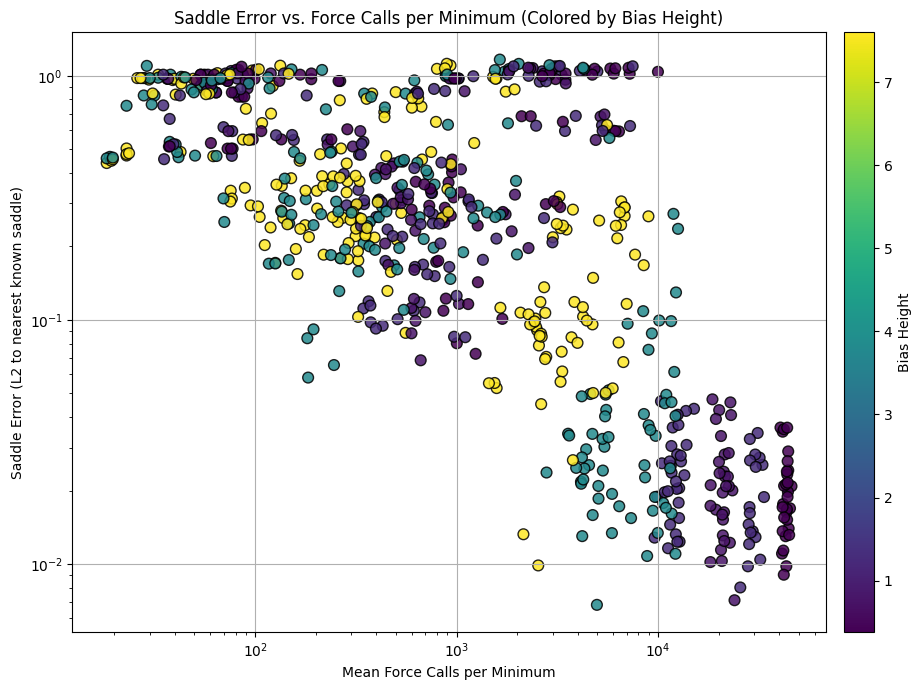

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

# Normalize bias_height across all individual runs
norm = Normalize(vmin=full_df['bias_height'].min(), vmax=full_df['bias_height'].max())
cmap = get_cmap('viridis')
colors = [cmap(norm(val)) for val in full_df['bias_height']]

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

sc = ax.scatter(
    full_df['mean_force_calls_per_min'],
    full_df['saddle_error_mean'],
    color=colors,
    s=60, alpha=0.85, edgecolors='k'
)

# Axis formatting
ax.set_xlabel("Mean Force Calls per Minimum")
ax.set_ylabel("Saddle Error (L2 to nearest known saddle)")
ax.set_title("Saddle Error vs. Force Calls per Minimum (Colored by Bias Height)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Bias Height")

plt.tight_layout()
plt.show()


/tmp/ipykernel_151617/2244042089.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


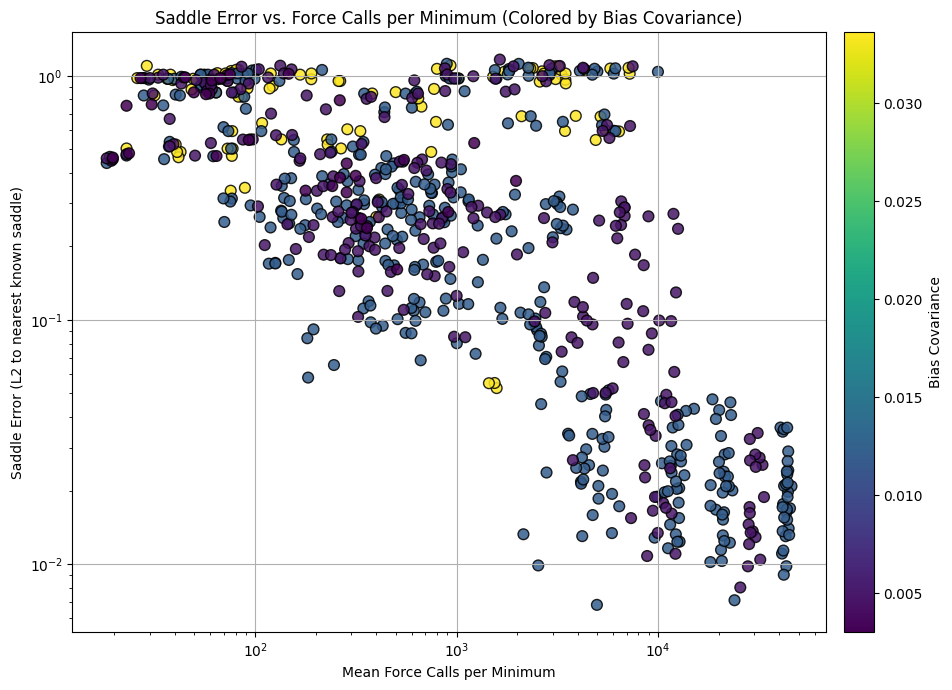

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

# Normalize bias_covariance across all individual runs
norm = Normalize(vmin=full_df['bias_covariance'].min(), vmax=full_df['bias_covariance'].max())
cmap = get_cmap('viridis')
colors = [cmap(norm(val)) for val in full_df['bias_covariance']]

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

sc = ax.scatter(
    full_df['mean_force_calls_per_min'],
    full_df['saddle_error_mean'],
    color=colors,
    s=60, alpha=0.85, edgecolors='k'
)

# Axis formatting
ax.set_xlabel("Mean Force Calls per Minimum")
ax.set_ylabel("Saddle Error (L2 to nearest known saddle)")
ax.set_title("Saddle Error vs. Force Calls per Minimum (Colored by Bias Covariance)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Bias Covariance")

plt.tight_layout()
plt.show()


/tmp/ipykernel_151617/1400633165.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


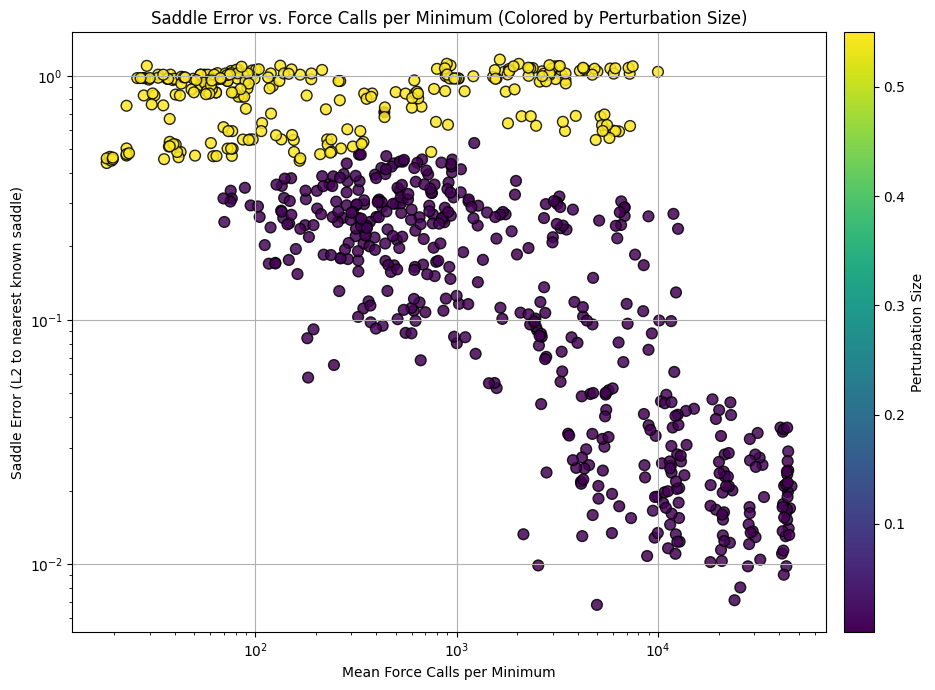

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

# Normalize perturbation_size across all individual runs
norm = Normalize(vmin=full_df['perturbation_size'].min(), vmax=full_df['perturbation_size'].max())
cmap = get_cmap('viridis')
colors = [cmap(norm(val)) for val in full_df['perturbation_size']]

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

sc = ax.scatter(
    full_df['mean_force_calls_per_min'],
    full_df['saddle_error_mean'],
    color=colors,
    s=60, alpha=0.85, edgecolors='k'
)

# Axis formatting
ax.set_xlabel("Mean Force Calls per Minimum")
ax.set_ylabel("Saddle Error (L2 to nearest known saddle)")
ax.set_title("Saddle Error vs. Force Calls per Minimum (Colored by Perturbation Size)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Perturbation Size")

plt.tight_layout()
plt.show()


In [6]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load Data ---
with open("new_mb_sweep.json", "r") as f:
    df = pd.DataFrame(json.load(f))
df.sort_values("run_id", inplace=True)

# --- Load Known Potential ---
from potentials import StandardMullerBrown2D
potential = StandardMullerBrown2D()
known_minima = potential.known_minima()
known_saddles = potential.known_saddles()

# --- Utilities ---
def l2_error_to_nearest(point, reference_list):
    return min(np.linalg.norm(np.array(point) - np.array(ref)) for ref in reference_list)

def standard_error(arr):
    arr = np.asarray(arr)
    return np.std(arr, ddof=1) / np.sqrt(len(arr)) if len(arr) > 1 else np.nan

def pad_and_stack_lists(list_of_lists):
    max_len = max(len(lst) for lst in list_of_lists)
    return np.array([list(lst) + [np.nan] * (max_len - len(lst)) for lst in list_of_lists])

def cumulative_to_diffs(lst):
    """Given cumulative list [x, x+y, x+y+z], return increments [x, y, z]."""
    arr = np.array(lst)
    diffs = np.diff(np.insert(arr, 0, 0))
    return diffs

# --- Config ---
N_SEEDS = 10  # adjust as needed
rows = []

# --- Process Blocks ---
for i in range(0, len(df), N_SEEDS):
    block = df.iloc[i:i+N_SEEDS]
    if len(block) < N_SEEDS:
        continue  # skip incomplete block

    all_saddles = []
    all_minima = []
    num_saddles_per_seed = []
    num_minima_per_seed = []

    for j in range(N_SEEDS):
        seed_saddles = block.iloc[j]['found_saddles']
        seed_minima = block.iloc[j]['found_minima']

        unique_saddles = list({tuple(s) for s in seed_saddles})
        unique_minima = list({tuple(m) for m in seed_minima})

        num_saddles_per_seed.append(len(unique_saddles))
        num_minima_per_seed.append(len(unique_minima))

        all_saddles.extend(unique_saddles)
        all_minima.extend(unique_minima)

    all_saddles = list({tuple(s) for s in all_saddles})
    all_minima = list({tuple(m) for m in all_minima})

    saddle_errors = [l2_error_to_nearest(sad, known_saddles) for sad in all_saddles]
    minima_errors = [l2_error_to_nearest(min_, known_minima) for min_ in all_minima]

    bias_counts = block['bias_count'].values

    summary = {
        'run_id': block['run_id'].min(),
        'saddle_error_mean': np.mean(saddle_errors),
        'saddle_error_stderr': standard_error(saddle_errors),
        'minima_error_mean': np.mean(minima_errors),
        'minima_error_stderr': standard_error(minima_errors),
        'bias_count_mean': np.mean(bias_counts),
        'bias_count_stderr': standard_error(bias_counts),
        'num_minima_mean': np.mean(num_minima_per_seed),
        'num_minima_stderr': standard_error(num_minima_per_seed),
        'num_saddles_mean': np.mean(num_saddles_per_seed),
        'num_saddles_stderr': standard_error(num_saddles_per_seed),
    }

    energy_lists = block['energy_calls_at_each_min'].tolist()
    force_lists = block['force_calls_at_each_min'].tolist()

    energy_increments = [cumulative_to_diffs(lst) for lst in energy_lists]
    force_increments = [cumulative_to_diffs(lst) for lst in force_lists]

    energy_array = pad_and_stack_lists(energy_increments)
    force_array = pad_and_stack_lists(force_increments)

    summary.update({
        'energy_calls_mean': np.nanmean(energy_array, axis=0).tolist(),
        'energy_calls_stderr': (np.nanstd(energy_array, axis=0, ddof=1) / np.sqrt(N_SEEDS)).tolist(),
        'force_calls_mean': np.nanmean(force_array, axis=0).tolist(),
        'force_calls_stderr': (np.nanstd(force_array, axis=0, ddof=1) / np.sqrt(N_SEEDS)).tolist(),

        'mean_force_calls_per_min': np.nanmean(force_array).item(),
        'stdv_force_calls_per_min': np.nanstd(force_array, ddof=1).item(),
        'mean_energy_calls_per_min': np.nanmean(energy_array).item(),
        'stdv_energy_calls_per_min': np.nanstd(energy_array, ddof=1).item(),
    })

    config_keys = [
        'bias_std_dev_scale', 'bias_covariance', 'bias_height_fraction',
        'bias_height', 'perturbation_size', 'optimizer'
    ]
    for key in config_keys:
        summary[key] = block.iloc[0][key]

    rows.append(summary)

# --- Aggregate and Filter ---
agg_df = pd.DataFrame(rows)
agg_df = agg_df[
    (agg_df['num_minima_mean'] == 3) &
    (agg_df['num_saddles_mean'] == 2)
].copy()


In [7]:
agg_df

,run_id,saddle_error_mean,saddle_error_stderr,minima_error_mean,minima_error_stderr,bias_count_mean,bias_count_stderr,num_minima_mean,num_minima_stderr,num_saddles_mean,...,mean_force_calls_per_min,stdv_force_calls_per_min,mean_energy_calls_per_min,stdv_energy_calls_per_min,bias_std_dev_scale,bias_covariance,bias_height_fraction,bias_height,perturbation_size,optimizer
0,0,0.805537,0.075369,9.492976e-04,3.892101e-04,17.5,2.709038,3.0,0.0,2.0,...,725.433333,861.874968,725.433333,861.874968,0.333333,0.033611,0.200000,7.600000,0.550,FIRE
1,10,0.849521,0.069805,2.334236e-05,1.166354e-05,11.0,1.751190,3.0,0.0,2.0,...,58.566667,82.209020,58.566667,82.209020,0.333333,0.033611,0.200000,7.600000,0.550,Scipy
4,168,0.836715,0.069608,9.316400e-06,3.686336e-06,22.2,4.918898,3.0,0.0,2.0,...,427.166667,1300.116973,427.166667,1300.116973,0.333333,0.033611,0.033333,1.266667,0.550,FIRE
7,326,0.850813,0.068210,5.143442e-06,1.755698e-06,62.2,14.007776,3.0,0.0,2.0,...,1909.266667,4703.988718,1909.266667,4703.988718,0.333333,0.033611,0.010000,0.380000,0.550,FIRE
9,417,0.404764,0.089019,1.053115e-04,8.610301e-05,53.6,9.872746,3.0,0.0,2.0,...,2020.066667,2925.521762,2020.066667,2925.521762,0.200000,0.012100,0.200000,7.600000,0.550,Scipy
10,427,0.248185,0.035147,1.327631e-04,1.026422e-04,40.8,6.579091,3.0,0.0,2.0,...,901.166667,1880.071717,901.166667,1880.071717,0.200000,0.012100,0.200000,7.600000,0.010,FIRE
11,437,0.187543,0.037931,1.122079e-04,8.576827e-05,54.5,8.426479,3.0,0.0,2.0,...,1971.000000,2934.825425,1971.000000,2934.825425,0.200000,0.012100,0.200000,7.600000,0.010,Scipy
12,447,0.203950,0.028078,1.430457e-04,1.088511e-04,45.8,8.444327,3.0,0.0,2.0,...,1032.033333,2181.895293,1032.033333,2181.895293,0.200000,0.012100,0.200000,7.600000,0.005,FIRE
13,457,0.180741,0.037766,1.061030e-04,8.135991e-05,57.0,6.907323,3.0,0.0,2.0,...,1987.333333,2817.713274,1987.333333,2817.713274,0.200000,0.012100,0.200000,7.600000,0.005,Scipy
14,467,0.204892,0.036307,1.347104e-04,1.016855e-04,54.8,6.271275,3.0,0.0,2.0,...,1094.333333,1991.975026,1094.333333,1991.975026,0.200000,0.012100,0.200000,7.600000,0.001,FIRE


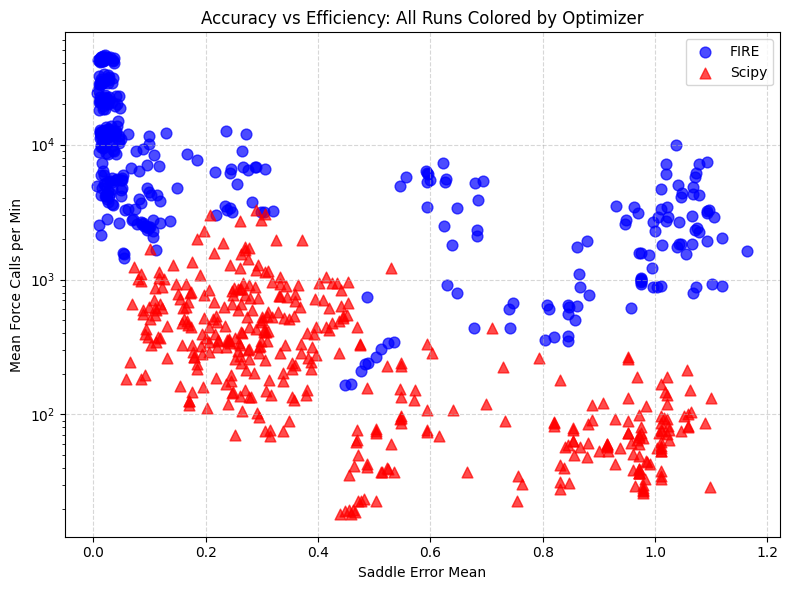

In [53]:
import matplotlib.pyplot as plt

# --- Split data by optimizer ---
fire_runs = full_df[full_df['optimizer'] == 'FIRE']
scipy_runs = full_df[full_df['optimizer'] == 'Scipy']

# --- Plot ---
plt.figure(figsize=(8, 6))

plt.scatter(
    fire_runs['saddle_error_mean'],
    fire_runs['mean_force_calls_per_min'],
    color='blue', label='FIRE', alpha=0.7, s=60, marker='o'
)
plt.scatter(
    scipy_runs['saddle_error_mean'],
    scipy_runs['mean_force_calls_per_min'],
    color='red', label='Scipy', alpha=0.7, s=60, marker='^'
)

# --- Labels, scale, and legend ---
plt.xlabel('Saddle Error Mean')
plt.ylabel('Mean Force Calls per Min')
plt.title('Accuracy vs Efficiency: All Runs Colored by Optimizer')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
agg_df

,run_id,saddle_error_mean,saddle_error_stderr,minima_error_mean,minima_error_stderr,bias_count_mean,bias_count_stderr,num_minima_mean,num_minima_stderr,num_saddles_mean,...,mean_force_calls_per_min,stdv_force_calls_per_min,mean_energy_calls_per_min,stdv_energy_calls_per_min,bias_std_dev_scale,bias_covariance,bias_height_fraction,bias_height,perturbation_size,optimizer
0,0,0.805537,0.075369,9.492976e-04,3.892101e-04,17.5,2.709038,3.0,0.0,2.0,...,725.433333,861.874968,725.433333,861.874968,0.333333,0.033611,0.200000,7.600000,0.550,FIRE
1,10,0.849521,0.069805,2.334236e-05,1.166354e-05,11.0,1.751190,3.0,0.0,2.0,...,58.566667,82.209020,58.566667,82.209020,0.333333,0.033611,0.200000,7.600000,0.550,Scipy
4,168,0.836715,0.069608,9.316400e-06,3.686336e-06,22.2,4.918898,3.0,0.0,2.0,...,427.166667,1300.116973,427.166667,1300.116973,0.333333,0.033611,0.033333,1.266667,0.550,FIRE
7,326,0.850813,0.068210,5.143442e-06,1.755698e-06,62.2,14.007776,3.0,0.0,2.0,...,1909.266667,4703.988718,1909.266667,4703.988718,0.333333,0.033611,0.010000,0.380000,0.550,FIRE
9,417,0.404764,0.089019,1.053115e-04,8.610301e-05,53.6,9.872746,3.0,0.0,2.0,...,2020.066667,2925.521762,2020.066667,2925.521762,0.200000,0.012100,0.200000,7.600000,0.550,Scipy
10,427,0.248185,0.035147,1.327631e-04,1.026422e-04,40.8,6.579091,3.0,0.0,2.0,...,901.166667,1880.071717,901.166667,1880.071717,0.200000,0.012100,0.200000,7.600000,0.010,FIRE
11,437,0.187543,0.037931,1.122079e-04,8.576827e-05,54.5,8.426479,3.0,0.0,2.0,...,1971.000000,2934.825425,1971.000000,2934.825425,0.200000,0.012100,0.200000,7.600000,0.010,Scipy
12,447,0.203950,0.028078,1.430457e-04,1.088511e-04,45.8,8.444327,3.0,0.0,2.0,...,1032.033333,2181.895293,1032.033333,2181.895293,0.200000,0.012100,0.200000,7.600000,0.005,FIRE
13,457,0.180741,0.037766,1.061030e-04,8.135991e-05,57.0,6.907323,3.0,0.0,2.0,...,1987.333333,2817.713274,1987.333333,2817.713274,0.200000,0.012100,0.200000,7.600000,0.005,Scipy
14,467,0.204892,0.036307,1.347104e-04,1.016855e-04,54.8,6.271275,3.0,0.0,2.0,...,1094.333333,1991.975026,1094.333333,1991.975026,0.200000,0.012100,0.200000,7.600000,0.001,FIRE


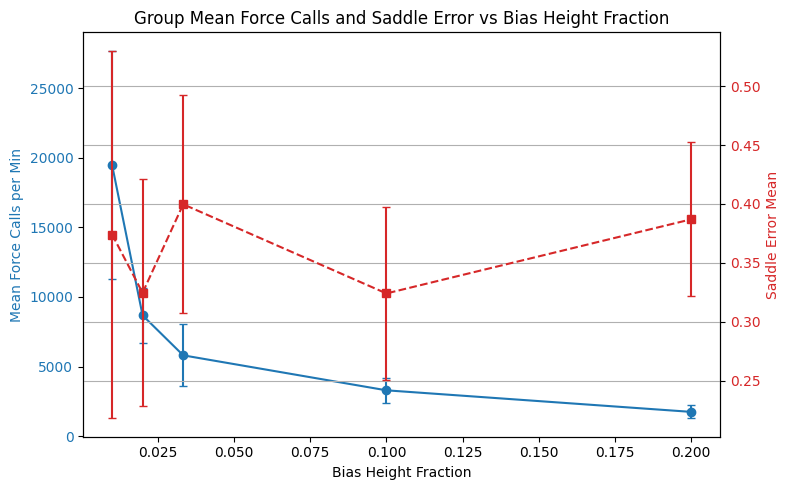

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Sanity check
assert (agg_df['mean_force_calls_per_min'] >= 0).all(), "Negative values in agg_df!"

# Filter valid entries
contender_params = agg_df[
    (agg_df['num_minima_mean'] == 3) &
    (agg_df['num_saddles_mean'] == 2)
].copy()

# Drop rows with missing values in key columns
contender_params = contender_params.dropna(subset=[
    'bias_height_fraction',
    'mean_force_calls_per_min', 'stdv_force_calls_per_min',
    'saddle_error_mean', 'saddle_error_stderr'
])

# Group and compute unweighted group statistics
grouped_df = (
    contender_params
    .groupby('bias_height_fraction')
    .agg({
        'mean_force_calls_per_min': ['mean', 'sem'],
        'saddle_error_mean': ['mean', 'sem']
    })
    .reset_index()
)

# Flatten column names
grouped_df.columns = [
    'bias_height_fraction',
    'mean_force_calls_per_min', 'std_force_calls_per_min',
    'mean_saddle_error', 'std_saddle_error'
]

# Assert no negatives again (we're being paranoid now)
assert (grouped_df['mean_force_calls_per_min'] >= 0).all(), "Negative values still present!"

# Plot
x = grouped_df['bias_height_fraction']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']

y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Height Fraction')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Group Mean Force Calls and Saddle Error vs Bias Height Fraction')
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
agg_df

,run_id,saddle_error_mean,saddle_error_stderr,minima_error_mean,minima_error_stderr,bias_count_mean,bias_count_stderr,num_minima_mean,num_minima_stderr,num_saddles_mean,...,mean_force_calls_per_min,stdv_force_calls_per_min,mean_energy_calls_per_min,stdv_energy_calls_per_min,bias_std_dev_scale,bias_covariance,bias_height_fraction,bias_height,perturbation_size,optimizer
0,0,0.805537,0.075369,9.492976e-04,3.892101e-04,17.5,2.709038,3.0,0.0,2.0,...,725.433333,861.874968,725.433333,861.874968,0.333333,0.033611,0.200000,7.600000,0.550,FIRE
1,10,0.849521,0.069805,2.334236e-05,1.166354e-05,11.0,1.751190,3.0,0.0,2.0,...,58.566667,82.209020,58.566667,82.209020,0.333333,0.033611,0.200000,7.600000,0.550,Scipy
4,168,0.836715,0.069608,9.316400e-06,3.686336e-06,22.2,4.918898,3.0,0.0,2.0,...,427.166667,1300.116973,427.166667,1300.116973,0.333333,0.033611,0.033333,1.266667,0.550,FIRE
7,326,0.850813,0.068210,5.143442e-06,1.755698e-06,62.2,14.007776,3.0,0.0,2.0,...,1909.266667,4703.988718,1909.266667,4703.988718,0.333333,0.033611,0.010000,0.380000,0.550,FIRE
9,417,0.404764,0.089019,1.053115e-04,8.610301e-05,53.6,9.872746,3.0,0.0,2.0,...,2020.066667,2925.521762,2020.066667,2925.521762,0.200000,0.012100,0.200000,7.600000,0.550,Scipy
10,427,0.248185,0.035147,1.327631e-04,1.026422e-04,40.8,6.579091,3.0,0.0,2.0,...,901.166667,1880.071717,901.166667,1880.071717,0.200000,0.012100,0.200000,7.600000,0.010,FIRE
11,437,0.187543,0.037931,1.122079e-04,8.576827e-05,54.5,8.426479,3.0,0.0,2.0,...,1971.000000,2934.825425,1971.000000,2934.825425,0.200000,0.012100,0.200000,7.600000,0.010,Scipy
12,447,0.203950,0.028078,1.430457e-04,1.088511e-04,45.8,8.444327,3.0,0.0,2.0,...,1032.033333,2181.895293,1032.033333,2181.895293,0.200000,0.012100,0.200000,7.600000,0.005,FIRE
13,457,0.180741,0.037766,1.061030e-04,8.135991e-05,57.0,6.907323,3.0,0.0,2.0,...,1987.333333,2817.713274,1987.333333,2817.713274,0.200000,0.012100,0.200000,7.600000,0.005,Scipy
14,467,0.204892,0.036307,1.347104e-04,1.016855e-04,54.8,6.271275,3.0,0.0,2.0,...,1094.333333,1991.975026,1094.333333,1991.975026,0.200000,0.012100,0.200000,7.600000,0.001,FIRE


Number of runs matching conditions: 2


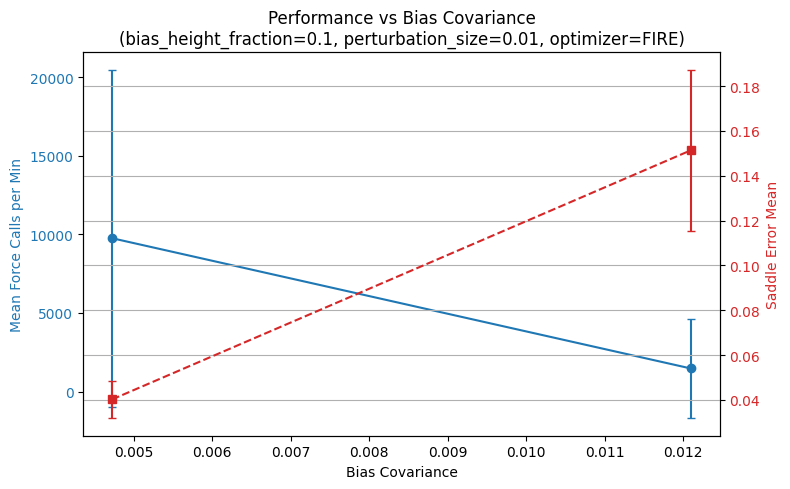

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Filter for given conditions and FIRE optimizer
bias_height_val = 0.1
perturbation_val = 0.01

subset = agg_df[
    (agg_df['bias_height_fraction'] == bias_height_val) &
    (agg_df['perturbation_size'] == perturbation_val) &
    (agg_df['optimizer'] == 'FIRE')
].copy()

print(f"Number of runs matching conditions: {len(subset)}")

# Weighted avg + SEM helper
def weighted_avg_and_sem(values, sems):
    values = np.asarray(values, dtype=float)
    sems = np.asarray(sems, dtype=float)
    sems[sems <= 0] = 1e-12
    valid = ~np.isnan(values) & ~np.isnan(sems)
    if valid.sum() == 0:
        return np.nan, np.nan
    weights = 1 / sems[valid]**2
    weighted_avg = np.sum(weights * values[valid]) / np.sum(weights)
    combined_sem = np.sqrt(1 / np.sum(weights))
    return weighted_avg, combined_sem

# Group by bias_covariance
grouped = []
for cov, group in subset.groupby('bias_covariance'):
    f_avg, f_sem = weighted_avg_and_sem(group['mean_force_calls_per_min'], group['stdv_force_calls_per_min'])
    s_avg, s_sem = weighted_avg_and_sem(group['saddle_error_mean'], group['saddle_error_stderr'])
    
    grouped.append({
        'bias_covariance': cov,
        'mean_force_calls_per_min': f_avg,
        'std_force_calls_per_min': f_sem,
        'mean_saddle_error': s_avg,
        'std_saddle_error': s_sem
    })

grouped_df = pd.DataFrame(grouped).sort_values('bias_covariance')

# Plot
x = grouped_df['bias_covariance']
y1 = grouped_df['mean_force_calls_per_min']
y1_err = grouped_df['std_force_calls_per_min']
y2 = grouped_df['mean_saddle_error']
y2_err = grouped_df['std_saddle_error']

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Bias Covariance')
ax1.set_ylabel('Mean Force Calls per Min', color=color1)
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_yscale('log')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Saddle Error Mean', color=color2)
ax2.errorbar(x, y2, yerr=y2_err, fmt='s--', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title(f"Performance vs Bias Covariance\n(bias_height_fraction={bias_height_val}, perturbation_size={perturbation_val}, optimizer=FIRE)")
plt.grid(True)
plt.tight_layout()
plt.show()
